In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

import data
import models
from models import *

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"
LATENT_DIM = 64
NUM_GENERATORS = 3

In [3]:
# We will work with the distilled data for the sake of simplicity of our work, it turns out that the distilled dataset contains only 0s and 1s

In [4]:
X_train, X_test, Y_train, Y_test = data.get_dataset_distilled()

train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

model_VAE = torch.load("../symmetry_2/VAE.pt")

In [5]:
model_VAE.eval()
train_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_train.to(device)))).cpu().detach()
test_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_test.to(device)))).cpu().detach()

train_dataset_Z = TensorDataset(train_Z,Y_train)
train_dataloader_Z = DataLoader(train_dataset_Z,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset_Z = TensorDataset(test_Z,Y_test)
test_dataloader_Z = DataLoader(test_dataset_Z,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [6]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fo = models.LatentDescriminator().to(device) # Since we ony have two elements

model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)


criterion_mse = nn.MSELoss()
criterion_BCE = nn.BCEWithLogitsLoss()

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    for Z,M in tqdm(train_dataloader_Z):
        Z = Z.to(device)
        M = M.to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        optimiser_symmetry.zero_grad()

        theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fo(Z)
        m_S = model_fo(Z_S)
        Z_P = model_fd(P)

        loss1 = criterion_BCE(m_S,torch.sigmoid(m))
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_BCE(m.squeeze(),M)
        
        loss_S = loss1 + loss2 + loss3
        # loss_Ae = loss5
        loss_Ae = loss5 + loss1 # Testing ...
        loss_O = loss6
        
        loss_S.backward(retain_graph=True)
        loss_Ae.backward(retain_graph=True)
        loss_O.backward(retain_graph=True)
        
        
        
        optimiser_fd.step()
        optimiser_fe.step()
        optimiser_fo.step()
        optimiser_symmetry.step()
    
        
        loss_S_closure_ += loss1.item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_oracle_ += loss6.item()
    
    loss_S_closure_ /= len(train_dataloader)
    loss_S_orth_ /= len(train_dataloader)
    loss_S_collapse_ /= len(train_dataloader)

    loss_space_ /= len(train_dataloader)
    loss_oracle_ /= len(train_dataloader)
    
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

100%|██████████| 227/227 [00:04<00:00, 49.94it/s]


EPOCH 0 complete
Symmetry Closure Loss  0.33117243083037995
Symmetry Orthogonality Loss  0.016222490836755424
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.1411152968433427
Oracle loss 0.14825075566932755


100%|██████████| 227/227 [00:04<00:00, 52.86it/s]


EPOCH 1 complete
Symmetry Closure Loss  0.07004281688104116
Symmetry Orthogonality Loss  0.005952418193073393
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012839105394863758
Oracle loss 0.014630477040562992


100%|██████████| 227/227 [00:03<00:00, 58.75it/s]


EPOCH 2 complete
Symmetry Closure Loss  0.024422176329968785
Symmetry Orthogonality Loss  0.005892295841669196
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00026664649433044035
Oracle loss 0.004038506385455901


100%|██████████| 227/227 [00:03<00:00, 57.24it/s]


EPOCH 3 complete
Symmetry Closure Loss  0.012089003472371511
Symmetry Orthogonality Loss  0.0056172699179286995
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001194740394679091
Oracle loss 0.0017767750339106644


100%|██████████| 227/227 [00:03<00:00, 59.04it/s]


EPOCH 4 complete
Symmetry Closure Loss  0.007181501526812231
Symmetry Orthogonality Loss  0.005572923005759585
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.221732630147721e-05
Oracle loss 0.000980583357261617


100%|██████████| 227/227 [00:03<00:00, 57.92it/s]


EPOCH 5 complete
Symmetry Closure Loss  0.004723254424039816
Symmetry Orthogonality Loss  0.005485176484178473
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.910428794376277e-05
Oracle loss 0.000611599600265656


100%|██████████| 227/227 [00:03<00:00, 57.89it/s]


EPOCH 6 complete
Symmetry Closure Loss  0.0033148751698746162
Symmetry Orthogonality Loss  0.0053673919745708615
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.357797119862631e-05
Oracle loss 0.0004124131071892062


100%|██████████| 227/227 [00:03<00:00, 57.59it/s]


EPOCH 7 complete
Symmetry Closure Loss  0.0024579486077331365
Symmetry Orthogonality Loss  0.0053449721149443795
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.918431631816497e-05
Oracle loss 0.0002959773576785585


100%|██████████| 227/227 [00:03<00:00, 60.11it/s]


EPOCH 8 complete
Symmetry Closure Loss  0.0018562591600843135
Symmetry Orthogonality Loss  0.005234919693567154
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.534983489421757e-05
Oracle loss 0.0002165982001107227


100%|██████████| 227/227 [00:03<00:00, 58.82it/s]


EPOCH 9 complete
Symmetry Closure Loss  0.0014596080237236448
Symmetry Orthogonality Loss  0.005317243318676555
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.5523202710164176e-05
Oracle loss 0.00016673524607083707


100%|██████████| 227/227 [00:03<00:00, 60.25it/s]


EPOCH 10 complete
Symmetry Closure Loss  0.001159367801586683
Symmetry Orthogonality Loss  0.005128013261384639
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.3064585146849356e-05
Oracle loss 0.00012986334367057244


100%|██████████| 227/227 [00:03<00:00, 58.80it/s]


EPOCH 11 complete
Symmetry Closure Loss  0.0009499633108319034
Symmetry Orthogonality Loss  0.005047240364262711
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.5234203003914893e-05
Oracle loss 0.00010445863336718556


100%|██████████| 227/227 [00:03<00:00, 58.45it/s]


EPOCH 12 complete
Symmetry Closure Loss  0.0007821245853366568
Symmetry Orthogonality Loss  0.005065289627563717
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.139740175968354e-05
Oracle loss 8.509810671293882e-05


100%|██████████| 227/227 [00:03<00:00, 59.24it/s]


EPOCH 13 complete
Symmetry Closure Loss  0.000642391078128984
Symmetry Orthogonality Loss  0.004958226659339299
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.883151283410879e-05
Oracle loss 6.839013422556254e-05


100%|██████████| 227/227 [00:03<00:00, 60.06it/s]


EPOCH 14 complete
Symmetry Closure Loss  0.0005352715212884585
Symmetry Orthogonality Loss  0.00486420398159568
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.3576158507986586e-05
Oracle loss 5.605909093536974e-05


100%|██████████| 227/227 [00:03<00:00, 59.91it/s]


EPOCH 15 complete
Symmetry Closure Loss  0.0004505139720700025
Symmetry Orthogonality Loss  0.0048393474908192775
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.78915724906903e-05
Oracle loss 4.6360470759831084e-05


100%|██████████| 227/227 [00:03<00:00, 59.52it/s]


EPOCH 16 complete
Symmetry Closure Loss  0.0003862553517157745
Symmetry Orthogonality Loss  0.00471732999497639
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.412320669794672e-05
Oracle loss 3.956796442978299e-05


100%|██████████| 227/227 [00:03<00:00, 58.88it/s]


EPOCH 17 complete
Symmetry Closure Loss  0.0003364417305275683
Symmetry Orthogonality Loss  0.0046646398377280665
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.016092419254313e-05
Oracle loss 3.434380513108448e-05


100%|██████████| 227/227 [00:03<00:00, 59.73it/s]


EPOCH 18 complete
Symmetry Closure Loss  0.0002849540315616654
Symmetry Orthogonality Loss  0.0046910415034298065
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.6357829166319334e-05
Oracle loss 2.8586992751953134e-05


100%|██████████| 227/227 [00:03<00:00, 61.34it/s]


EPOCH 19 complete
Symmetry Closure Loss  0.00024527994854814714
Symmetry Orthogonality Loss  0.004694997000668017
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.033530466293463e-05
Oracle loss 2.4450069314310183e-05


100%|██████████| 227/227 [00:03<00:00, 58.48it/s]


EPOCH 20 complete
Symmetry Closure Loss  0.00022055677466231935
Symmetry Orthogonality Loss  0.004787531176721472
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.680386099395509e-05
Oracle loss 2.2467837719694713e-05


100%|██████████| 227/227 [00:03<00:00, 58.35it/s]


EPOCH 21 complete
Symmetry Closure Loss  0.0001873646475993187
Symmetry Orthogonality Loss  0.004546114561529543
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.412785907205972e-05
Oracle loss 1.8632890658705937e-05


100%|██████████| 227/227 [00:03<00:00, 59.68it/s]


EPOCH 22 complete
Symmetry Closure Loss  0.0001638706271318177
Symmetry Orthogonality Loss  0.004526928482610027
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.267764196217602e-05
Oracle loss 1.6189946036961233e-05


100%|██████████| 227/227 [00:03<00:00, 60.01it/s]


EPOCH 23 complete
Symmetry Closure Loss  0.00014364088699965233
Symmetry Orthogonality Loss  0.0043803801050303
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.541862722462731e-05
Oracle loss 1.3955445789451514e-05


100%|██████████| 227/227 [00:03<00:00, 59.54it/s]


EPOCH 24 complete
Symmetry Closure Loss  0.0001265347837434573
Symmetry Orthogonality Loss  0.004297133214107103
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.723331603439682e-05
Oracle loss 1.2345476610517327e-05


100%|██████████| 227/227 [00:03<00:00, 59.61it/s]


EPOCH 25 complete
Symmetry Closure Loss  0.00010961215523336214
Symmetry Orthogonality Loss  0.004225462445341018
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.7197440282680406e-05
Oracle loss 1.0549900411214195e-05


100%|██████████| 227/227 [00:03<00:00, 59.19it/s]


EPOCH 26 complete
Symmetry Closure Loss  0.00010027593789385767
Symmetry Orthogonality Loss  0.004204843575873367
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.731382575545215e-05
Oracle loss 9.676611443464455e-06


100%|██████████| 227/227 [00:03<00:00, 60.21it/s]


EPOCH 27 complete
Symmetry Closure Loss  8.564085835777634e-05
Symmetry Orthogonality Loss  0.004076881311620516
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.398629198676885e-05
Oracle loss 8.12846820888263e-06


100%|██████████| 227/227 [00:03<00:00, 60.26it/s]


EPOCH 28 complete
Symmetry Closure Loss  7.349764809626798e-05
Symmetry Orthogonality Loss  0.00399198735108197
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.328638066111442e-05
Oracle loss 6.824450862032963e-06


100%|██████████| 227/227 [00:03<00:00, 60.75it/s]


EPOCH 29 complete
Symmetry Closure Loss  6.772093916230318e-05
Symmetry Orthogonality Loss  0.003939899162590373
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.158374066907571e-05
Oracle loss 6.4167601770466495e-06


100%|██████████| 227/227 [00:03<00:00, 59.31it/s]


EPOCH 30 complete
Symmetry Closure Loss  6.145107296098276e-05
Symmetry Orthogonality Loss  0.003926892075605592
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.7904493309306016e-05
Oracle loss 5.822299853996666e-06


100%|██████████| 227/227 [00:03<00:00, 58.74it/s]


EPOCH 31 complete
Symmetry Closure Loss  5.368573241033756e-05
Symmetry Orthogonality Loss  0.0038183174169897243
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.1861787108266095e-05
Oracle loss 4.994242331502849e-06


100%|██████████| 227/227 [00:03<00:00, 59.67it/s]


EPOCH 32 complete
Symmetry Closure Loss  4.8051836901951567e-05
Symmetry Orthogonality Loss  0.00369117419145148
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.653562988769489e-05
Oracle loss 4.532345638587569e-06


100%|██████████| 227/227 [00:03<00:00, 59.14it/s]


EPOCH 33 complete
Symmetry Closure Loss  4.041926584626796e-05
Symmetry Orthogonality Loss  0.00364210086234636
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.1769532755590124e-05
Oracle loss 3.6473019626569494e-06


100%|██████████| 227/227 [00:03<00:00, 58.62it/s]


EPOCH 34 complete
Symmetry Closure Loss  3.7431400799421214e-05
Symmetry Orthogonality Loss  0.003684810205826347
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.357293719615357e-05
Oracle loss 3.3897444403126206e-06


100%|██████████| 227/227 [00:03<00:00, 59.06it/s]


EPOCH 35 complete
Symmetry Closure Loss  3.230954632877181e-05
Symmetry Orthogonality Loss  0.003542262744897
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.713638065873116e-05
Oracle loss 2.937359070705345e-06


100%|██████████| 227/227 [00:03<00:00, 59.12it/s]


EPOCH 36 complete
Symmetry Closure Loss  3.37266064729e-05
Symmetry Orthogonality Loss  0.0035723552296537133
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.024845020066524e-05
Oracle loss 3.305192460539621e-06


100%|██████████| 227/227 [00:03<00:00, 59.94it/s]


EPOCH 37 complete
Symmetry Closure Loss  2.7007062796740238e-05
Symmetry Orthogonality Loss  0.0035396614040161937
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.075290337418724e-05
Oracle loss 2.4656850352949623e-06


100%|██████████| 227/227 [00:03<00:00, 60.35it/s]


EPOCH 38 complete
Symmetry Closure Loss  2.2251860910339644e-05
Symmetry Orthogonality Loss  0.0034945546382718147
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.406323578343434e-05
Oracle loss 1.9402625744659205e-06


100%|██████████| 227/227 [00:03<00:00, 59.04it/s]


EPOCH 39 complete
Symmetry Closure Loss  2.2203914140605488e-05
Symmetry Orthogonality Loss  0.003472718556866969
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.98977017258976e-05
Oracle loss 2.032668150919394e-06


100%|██████████| 227/227 [00:03<00:00, 59.83it/s]


EPOCH 40 complete
Symmetry Closure Loss  1.94737770106366e-05
Symmetry Orthogonality Loss  0.003392523618226272
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.4299429055372696e-05
Oracle loss 1.7636136562180578e-06


100%|██████████| 227/227 [00:03<00:00, 59.39it/s]


EPOCH 41 complete
Symmetry Closure Loss  1.6713123841327615e-05
Symmetry Orthogonality Loss  0.003281716964031172
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.087401926713008e-05
Oracle loss 1.4912260761593243e-06


100%|██████████| 227/227 [00:03<00:00, 59.82it/s]


EPOCH 42 complete
Symmetry Closure Loss  1.456734299901278e-05
Symmetry Orthogonality Loss  0.0033612815767838436
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.649967724381675e-05
Oracle loss 1.2686247916136352e-06


100%|██████████| 227/227 [00:03<00:00, 59.95it/s]


EPOCH 43 complete
Symmetry Closure Loss  1.6351554457022985e-05
Symmetry Orthogonality Loss  0.0033240282604479056
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.279799747167887e-05
Oracle loss 1.6074474587583906e-06


100%|██████████| 227/227 [00:03<00:00, 60.14it/s]


EPOCH 44 complete
Symmetry Closure Loss  1.1472266195865045e-05
Symmetry Orthogonality Loss  0.003206943348460392
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.918839307328154e-05
Oracle loss 9.842524712044978e-07


100%|██████████| 227/227 [00:03<00:00, 59.61it/s]


EPOCH 45 complete
Symmetry Closure Loss  1.0582953873661945e-05
Symmetry Orthogonality Loss  0.0031605201808218783
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.545303163828499e-05
Oracle loss 9.202909559152059e-07


100%|██████████| 227/227 [00:03<00:00, 60.80it/s]


EPOCH 46 complete
Symmetry Closure Loss  9.70295100500561e-06
Symmetry Orthogonality Loss  0.0031373515214344347
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.3781343872640575e-05
Oracle loss 8.146741739870568e-07


100%|██████████| 227/227 [00:03<00:00, 59.28it/s]


EPOCH 47 complete
Symmetry Closure Loss  8.319024363867163e-06
Symmetry Orthogonality Loss  0.0031149546515262206
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.096480829963737e-05
Oracle loss 6.95516371865378e-07


100%|██████████| 227/227 [00:03<00:00, 59.22it/s]


EPOCH 48 complete
Symmetry Closure Loss  8.14853544522124e-06
Symmetry Orthogonality Loss  0.0031358977094588037
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.66180042952543e-05
Oracle loss 6.710243028209482e-07


100%|██████████| 227/227 [00:03<00:00, 60.34it/s]


EPOCH 49 complete
Symmetry Closure Loss  7.705432762671557e-06
Symmetry Orthogonality Loss  0.003042148735932185
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.7335933346200925e-05
Oracle loss 6.633947733193823e-07


100%|██████████| 227/227 [00:03<00:00, 60.01it/s]


EPOCH 50 complete
Symmetry Closure Loss  6.783198111030199e-06
Symmetry Orthogonality Loss  0.0029773031728596547
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.774230284489423e-05
Oracle loss 5.601011393814147e-07


100%|██████████| 227/227 [00:03<00:00, 59.34it/s]


EPOCH 51 complete
Symmetry Closure Loss  5.240221540561072e-06
Symmetry Orthogonality Loss  0.0029332907767843307
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.205444854015107e-05
Oracle loss 4.1673393832973843e-07


100%|██████████| 227/227 [00:03<00:00, 58.64it/s]


EPOCH 52 complete
Symmetry Closure Loss  5.435180065585337e-06
Symmetry Orthogonality Loss  0.0028764409667479964
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.645196820878578e-05
Oracle loss 4.030796101085393e-07


100%|██████████| 227/227 [00:03<00:00, 60.88it/s]


EPOCH 53 complete
Symmetry Closure Loss  4.639538650833792e-06
Symmetry Orthogonality Loss  0.002786380835780094
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.894500526453939e-05
Oracle loss 3.804087823873047e-07


100%|██████████| 227/227 [00:03<00:00, 60.00it/s]


EPOCH 54 complete
Symmetry Closure Loss  4.747994431366427e-06
Symmetry Orthogonality Loss  0.0027685705274917874
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.656572164595973e-05
Oracle loss 4.101697937890415e-07


100%|██████████| 227/227 [00:03<00:00, 59.16it/s]


EPOCH 55 complete
Symmetry Closure Loss  3.3038904304787604e-06
Symmetry Orthogonality Loss  0.002755415123284257
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.051445415272674e-05
Oracle loss 2.4305531839168436e-07


100%|██████████| 227/227 [00:03<00:00, 60.20it/s]


EPOCH 56 complete
Symmetry Closure Loss  3.5982184517546363e-06
Symmetry Orthogonality Loss  0.0027706488045876115
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.749613189722472e-05
Oracle loss 3.0427220878357724e-07


100%|██████████| 227/227 [00:03<00:00, 60.18it/s]


EPOCH 57 complete
Symmetry Closure Loss  3.6753357350353165e-06
Symmetry Orthogonality Loss  0.002734823178065046
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.177702239437692e-05
Oracle loss 3.0317013646666735e-07


100%|██████████| 227/227 [00:03<00:00, 60.03it/s]


EPOCH 58 complete
Symmetry Closure Loss  2.6580102861859738e-06
Symmetry Orthogonality Loss  0.002588331149603827
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.389117360343074e-05
Oracle loss 2.155671739868589e-07


100%|██████████| 227/227 [00:03<00:00, 60.41it/s]


EPOCH 59 complete
Symmetry Closure Loss  2.2128091353003346e-06
Symmetry Orthogonality Loss  0.0025532604697763527
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.958797845567332e-05
Oracle loss 1.7724123130500577e-07


100%|██████████| 227/227 [00:03<00:00, 60.07it/s]


EPOCH 60 complete
Symmetry Closure Loss  2.0620831768077637e-06
Symmetry Orthogonality Loss  0.002488055462345875
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.7429956579930274e-05
Oracle loss 1.486021996947709e-07


100%|██████████| 227/227 [00:03<00:00, 60.68it/s]


EPOCH 61 complete
Symmetry Closure Loss  0.0001147437981737937
Symmetry Orthogonality Loss  0.0026793989428782646
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013976968070631899
Oracle loss 2.3452687244027638e-07


100%|██████████| 227/227 [00:03<00:00, 60.84it/s]


EPOCH 62 complete
Symmetry Closure Loss  5.559051213129247e-06
Symmetry Orthogonality Loss  0.0027366571686341374
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012511419311718653
Oracle loss 2.9689292123545516e-07


100%|██████████| 227/227 [00:03<00:00, 60.81it/s]


EPOCH 63 complete
Symmetry Closure Loss  4.254396190296098e-06
Symmetry Orthogonality Loss  0.0026437809633394695
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.781262577613939e-05
Oracle loss 1.42773651650173e-07


100%|██████████| 227/227 [00:03<00:00, 58.82it/s]


EPOCH 64 complete
Symmetry Closure Loss  2.8417005836570447e-06
Symmetry Orthogonality Loss  0.0025822804853041135
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.939301502658952e-05
Oracle loss 1.1856999390548052e-07


100%|██████████| 227/227 [00:03<00:00, 57.84it/s]


EPOCH 65 complete
Symmetry Closure Loss  3.2687819239978757e-06
Symmetry Orthogonality Loss  0.0024675228448363127
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.031086043986012e-05
Oracle loss 9.979295430926564e-08


100%|██████████| 227/227 [00:03<00:00, 60.05it/s]


EPOCH 66 complete
Symmetry Closure Loss  2.7473069464410563e-06
Symmetry Orthogonality Loss  0.0024572649564479155
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.9679402427873236e-05
Oracle loss 8.096758421045517e-08


100%|██████████| 227/227 [00:03<00:00, 60.23it/s]


EPOCH 67 complete
Symmetry Closure Loss  2.510804273332331e-06
Symmetry Orthogonality Loss  0.002450525222165666
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.670360323013727e-05
Oracle loss 1.0962411290816939e-07


100%|██████████| 227/227 [00:03<00:00, 60.28it/s]


EPOCH 68 complete
Symmetry Closure Loss  1.5288992547174637e-06
Symmetry Orthogonality Loss  0.0024097404598631784
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.989578043837303e-05
Oracle loss 5.919982598799043e-08


100%|██████████| 227/227 [00:03<00:00, 61.12it/s]


EPOCH 69 complete
Symmetry Closure Loss  1.1500984110716872e-06
Symmetry Orthogonality Loss  0.0024366714696231655
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.2211769169683946e-05
Oracle loss 5.411118896864651e-08


100%|██████████| 227/227 [00:03<00:00, 59.54it/s]


EPOCH 70 complete
Symmetry Closure Loss  1.0356573198719922e-06
Symmetry Orthogonality Loss  0.002438123223047687
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.014693651481243e-05
Oracle loss 5.048750270227402e-08


100%|██████████| 227/227 [00:03<00:00, 59.12it/s]


EPOCH 71 complete
Symmetry Closure Loss  1.3170786099965775e-06
Symmetry Orthogonality Loss  0.0023601996724694836
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.368325147848216e-05
Oracle loss 6.989228317587867e-08


100%|██████████| 227/227 [00:03<00:00, 60.83it/s]


EPOCH 72 complete
Symmetry Closure Loss  9.900774075556745e-07
Symmetry Orthogonality Loss  0.0023184054508591932
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.5039096173365184e-05
Oracle loss 5.2020020526615555e-08


100%|██████████| 227/227 [00:03<00:00, 59.86it/s]


EPOCH 73 complete
Symmetry Closure Loss  8.561907884153005e-07
Symmetry Orthogonality Loss  0.00228353184729913
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.062397764423041e-05
Oracle loss 3.590093691884365e-08


100%|██████████| 227/227 [00:03<00:00, 58.97it/s]


EPOCH 74 complete
Symmetry Closure Loss  9.229784359139045e-07
Symmetry Orthogonality Loss  0.002212917089609979
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.5747099986759766e-05
Oracle loss 3.90089099495173e-08


100%|██████████| 227/227 [00:03<00:00, 61.88it/s]


EPOCH 75 complete
Symmetry Closure Loss  1.1571818221061136e-06
Symmetry Orthogonality Loss  0.0022021960041440597
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.258267564474942e-05
Oracle loss 4.5397020245152967e-08


100%|██████████| 227/227 [00:03<00:00, 59.68it/s]


EPOCH 76 complete
Symmetry Closure Loss  7.643354524219729e-07
Symmetry Orthogonality Loss  0.002217898737138654
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.178210344858863e-05
Oracle loss 3.1130129606863776e-08


100%|██████████| 227/227 [00:03<00:00, 59.86it/s]


EPOCH 77 complete
Symmetry Closure Loss  6.7721765022807e-07
Symmetry Orthogonality Loss  0.002205660563610527
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.3286547488285195e-05
Oracle loss 2.013156650755436e-08


100%|██████████| 227/227 [00:03<00:00, 58.74it/s]


EPOCH 78 complete
Symmetry Closure Loss  6.192253557255533e-07
Symmetry Orthogonality Loss  0.0021222298944344343
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.472738241409372e-05
Oracle loss 1.7517434617524232e-08


100%|██████████| 227/227 [00:03<00:00, 59.95it/s]


EPOCH 79 complete
Symmetry Closure Loss  5.145179961693699e-07
Symmetry Orthogonality Loss  0.002047480998913622
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.405304608546302e-05
Oracle loss 1.7269085093697757e-08


100%|██████████| 227/227 [00:03<00:00, 59.33it/s]


EPOCH 80 complete
Symmetry Closure Loss  4.802689135705212e-07
Symmetry Orthogonality Loss  0.002012063980426656
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.877890957691375e-05
Oracle loss 1.492521732263267e-08


100%|██████████| 227/227 [00:03<00:00, 59.65it/s]


EPOCH 81 complete
Symmetry Closure Loss  8.327622561380905e-07
Symmetry Orthogonality Loss  0.002018737803123038
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.6177891922311035e-05
Oracle loss 1.9958867536547052e-08


100%|██████████| 227/227 [00:03<00:00, 59.52it/s]


EPOCH 82 complete
Symmetry Closure Loss  4.187899376007187e-07
Symmetry Orthogonality Loss  0.001929858479431383
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.0400616875766966e-05
Oracle loss 1.7774830017488918e-08


100%|██████████| 227/227 [00:03<00:00, 59.45it/s]


EPOCH 83 complete
Symmetry Closure Loss  3.125622975321896e-07
Symmetry Orthogonality Loss  0.0019121715206127728
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.224839123191839e-05
Oracle loss 1.1758063075313685e-08


100%|██████████| 227/227 [00:03<00:00, 59.74it/s]


EPOCH 84 complete
Symmetry Closure Loss  4.033239328184248e-07
Symmetry Orthogonality Loss  0.0019318673422248286
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.643692038756469e-05
Oracle loss 1.186058904999146e-08


100%|██████████| 227/227 [00:03<00:00, 60.87it/s]


EPOCH 85 complete
Symmetry Closure Loss  4.03833643920923e-07
Symmetry Orthogonality Loss  0.0019001493303285755
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.554429351588576e-05
Oracle loss 1.1517158216293515e-08


100%|██████████| 227/227 [00:03<00:00, 60.37it/s]


EPOCH 86 complete
Symmetry Closure Loss  4.26561966561409e-07
Symmetry Orthogonality Loss  0.0018447171686430531
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.22010461199739e-05
Oracle loss 3.127240110180371e-08


100%|██████████| 227/227 [00:03<00:00, 59.83it/s]


EPOCH 87 complete
Symmetry Closure Loss  2.300957548215818e-07
Symmetry Orthogonality Loss  0.0018262396774783992
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.721869185060534e-05
Oracle loss 9.581346906646399e-09


100%|██████████| 227/227 [00:03<00:00, 58.28it/s]


EPOCH 88 complete
Symmetry Closure Loss  0.0001295805217218025
Symmetry Orthogonality Loss  0.0018827587320973957
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014074509260638274
Oracle loss 2.129747916074892e-08


100%|██████████| 227/227 [00:03<00:00, 59.03it/s]


EPOCH 89 complete
Symmetry Closure Loss  1.4474194371022218e-05
Symmetry Orthogonality Loss  0.0018446394647492121
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.493923016054307e-05
Oracle loss 1.6884318907030177e-08


100%|██████████| 227/227 [00:03<00:00, 60.45it/s]


EPOCH 90 complete
Symmetry Closure Loss  8.135001779614548e-06
Symmetry Orthogonality Loss  0.0018585542907183456
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.4819916548781272e-05
Oracle loss 1.4522291002448203e-08


100%|██████████| 227/227 [00:03<00:00, 61.18it/s]


EPOCH 91 complete
Symmetry Closure Loss  2.5927096492435665e-05
Symmetry Orthogonality Loss  0.0018757766539370436
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010677655533344986
Oracle loss 4.29347000983042e-09


100%|██████████| 227/227 [00:03<00:00, 59.04it/s]


EPOCH 92 complete
Symmetry Closure Loss  1.6298649263547726e-06
Symmetry Orthogonality Loss  0.001836207572223069
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.399553683131015e-06
Oracle loss 4.432960555657657e-09


100%|██████████| 227/227 [00:03<00:00, 60.36it/s]


EPOCH 93 complete
Symmetry Closure Loss  1.6192314492466375e-06
Symmetry Orthogonality Loss  0.0017732193335554345
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.2654694554060445e-05
Oracle loss 4.247284817290216e-09


100%|██████████| 227/227 [00:03<00:00, 60.78it/s]


EPOCH 94 complete
Symmetry Closure Loss  1.533653210028127e-06
Symmetry Orthogonality Loss  0.0017383535123852774
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.843940928588345e-05
Oracle loss 8.086910231588733e-09


100%|██████████| 227/227 [00:03<00:00, 59.81it/s]


EPOCH 95 complete
Symmetry Closure Loss  1.552814204937309e-06
Symmetry Orthogonality Loss  0.0017216442879043224
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.4764060593759992e-05
Oracle loss 3.808322112448711e-09


100%|██████████| 227/227 [00:03<00:00, 60.43it/s]


EPOCH 96 complete
Symmetry Closure Loss  7.975506576787866e-07
Symmetry Orthogonality Loss  0.0017222931376752744
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.4142664211653715e-05
Oracle loss 2.8708675276130314e-09


100%|██████████| 227/227 [00:03<00:00, 59.96it/s]


EPOCH 97 complete
Symmetry Closure Loss  1.9348899376341673e-06
Symmetry Orthogonality Loss  0.0017129947787298439
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.815906309217996e-05
Oracle loss 4.8377584747165355e-09


100%|██████████| 227/227 [00:03<00:00, 60.09it/s]


EPOCH 98 complete
Symmetry Closure Loss  7.250222289347972e-07
Symmetry Orthogonality Loss  0.0017216692648885468
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.427829287729035e-05
Oracle loss 1.7323628026459838e-09


100%|██████████| 227/227 [00:03<00:00, 60.46it/s]


EPOCH 99 complete
Symmetry Closure Loss  3.496610877570548e-07
Symmetry Orthogonality Loss  0.0017064634909533325
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.1270467897658244e-05
Oracle loss 1.3487737203419686e-09


100%|██████████| 227/227 [00:03<00:00, 59.05it/s]


EPOCH 100 complete
Symmetry Closure Loss  4.600977011325223e-07
Symmetry Orthogonality Loss  0.0016298248521811308
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.263222942071115e-05
Oracle loss 1.2585133755000324e-09


100%|██████████| 227/227 [00:03<00:00, 59.57it/s]


EPOCH 101 complete
Symmetry Closure Loss  2.5398733209418797e-07
Symmetry Orthogonality Loss  0.001589809700801542
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.425585699141975e-05
Oracle loss 1.253384664045484e-09


100%|██████████| 227/227 [00:03<00:00, 60.45it/s]


EPOCH 102 complete
Symmetry Closure Loss  2.9759761616146047e-07
Symmetry Orthogonality Loss  0.001578303795032991
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.894044117372094e-05
Oracle loss 2.8000358515525763e-09


100%|██████████| 227/227 [00:03<00:00, 59.06it/s]


EPOCH 103 complete
Symmetry Closure Loss  4.494163675205075e-07
Symmetry Orthogonality Loss  0.0015750072910840158
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.529982325790716e-05
Oracle loss 3.460539900890187e-09


100%|██████████| 227/227 [00:03<00:00, 60.37it/s]


EPOCH 104 complete
Symmetry Closure Loss  7.79881850386344e-07
Symmetry Orthogonality Loss  0.001529684209773555
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.514149907179335e-05
Oracle loss 3.542378695930992e-09


100%|██████████| 227/227 [00:03<00:00, 59.95it/s]


EPOCH 105 complete
Symmetry Closure Loss  4.5589732323288713e-07
Symmetry Orthogonality Loss  0.0015098710215162273
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.5293088365001435e-05
Oracle loss 3.2533122857441825e-09


100%|██████████| 227/227 [00:03<00:00, 59.80it/s]


EPOCH 106 complete
Symmetry Closure Loss  3.313150213039649e-07
Symmetry Orthogonality Loss  0.001460436839786756
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.049369414385667e-05
Oracle loss 1.3631263509042289e-09


100%|██████████| 227/227 [00:03<00:00, 61.00it/s]


EPOCH 107 complete
Symmetry Closure Loss  2.5211588211251874e-06
Symmetry Orthogonality Loss  0.0014567427795651134
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.167363162744418e-05
Oracle loss 7.939401812868713e-09


100%|██████████| 227/227 [00:03<00:00, 60.02it/s]


EPOCH 108 complete
Symmetry Closure Loss  3.4520252428122165e-07
Symmetry Orthogonality Loss  0.001446184677601123
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.881263859480375e-05
Oracle loss 1.9405753094144797e-09


100%|██████████| 227/227 [00:03<00:00, 58.64it/s]


EPOCH 109 complete
Symmetry Closure Loss  2.2571456862421962e-06
Symmetry Orthogonality Loss  0.0014401397791933186
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.430303579180436e-05
Oracle loss 1.679040163757196e-09


100%|██████████| 227/227 [00:03<00:00, 59.14it/s]


EPOCH 110 complete
Symmetry Closure Loss  0.00032229273568460217
Symmetry Orthogonality Loss  0.0016319155518687639
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020788144887261407
Oracle loss 1.0298355890953877e-08


100%|██████████| 227/227 [00:03<00:00, 59.26it/s]


EPOCH 111 complete
Symmetry Closure Loss  0.00016162388245025982
Symmetry Orthogonality Loss  0.0015320730870507558
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001066272554950279
Oracle loss 7.914826856322722e-09


100%|██████████| 227/227 [00:03<00:00, 59.43it/s]


EPOCH 112 complete
Symmetry Closure Loss  3.5653804700463538e-06
Symmetry Orthogonality Loss  0.0014498652315940626
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.255009816914626e-05
Oracle loss 5.002991114817394e-09


100%|██████████| 227/227 [00:03<00:00, 59.12it/s]


EPOCH 113 complete
Symmetry Closure Loss  3.5898784843262767e-06
Symmetry Orthogonality Loss  0.0014178182458964542
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.863842833935671e-05
Oracle loss 3.95492693715561e-09


100%|██████████| 227/227 [00:03<00:00, 60.65it/s]


EPOCH 114 complete
Symmetry Closure Loss  4.419778054391839e-06
Symmetry Orthogonality Loss  0.0014214513880828404
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.7614441624603342e-05
Oracle loss 3.6254927989636557e-09


100%|██████████| 227/227 [00:03<00:00, 59.62it/s]


EPOCH 115 complete
Symmetry Closure Loss  8.589110399424171e-06
Symmetry Orthogonality Loss  0.0014439291738195237
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.128616975392367e-05
Oracle loss 8.29335113511867e-09


100%|██████████| 227/227 [00:03<00:00, 57.48it/s]


EPOCH 116 complete
Symmetry Closure Loss  1.4399738265529703e-06
Symmetry Orthogonality Loss  0.0014138081719245483
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.470631667377175e-05
Oracle loss 2.800961587056493e-09


100%|██████████| 227/227 [00:03<00:00, 59.79it/s]


EPOCH 117 complete
Symmetry Closure Loss  2.241685348126011e-06
Symmetry Orthogonality Loss  0.0013969760846617397
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.02873548201501e-05
Oracle loss 6.100329187648823e-09


100%|██████████| 227/227 [00:03<00:00, 58.21it/s]


EPOCH 118 complete
Symmetry Closure Loss  1.4402506836922404e-06
Symmetry Orthogonality Loss  0.0013986180479010559
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.56443353267975e-05
Oracle loss 1.2523493355289774e-09


100%|██████████| 227/227 [00:03<00:00, 59.82it/s]


EPOCH 119 complete
Symmetry Closure Loss  1.925217702873621e-06
Symmetry Orthogonality Loss  0.0013524673551952853
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.402566965085073e-05
Oracle loss 4.59062671203651e-09


100%|██████████| 227/227 [00:03<00:00, 60.14it/s]


EPOCH 120 complete
Symmetry Closure Loss  8.395427895068378e-07
Symmetry Orthogonality Loss  0.0013132993719593873
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.24331152723367e-06
Oracle loss 4.824033022040504e-09


100%|██████████| 227/227 [00:03<00:00, 57.87it/s]


EPOCH 121 complete
Symmetry Closure Loss  1.163158406103762e-06
Symmetry Orthogonality Loss  0.0013197378085163065
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.3115969149889176e-05
Oracle loss 1.6564247718803247e-09


100%|██████████| 227/227 [00:04<00:00, 55.09it/s]


EPOCH 122 complete
Symmetry Closure Loss  1.2771288719463675e-06
Symmetry Orthogonality Loss  0.001287078589512782
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.366274876384199e-05
Oracle loss 1.7220993112920703e-09


100%|██████████| 227/227 [00:03<00:00, 57.42it/s]


EPOCH 123 complete
Symmetry Closure Loss  5.745017728517357e-07
Symmetry Orthogonality Loss  0.0012980513290054931
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.9132063709446425e-05
Oracle loss 2.0286389341500596e-09


100%|██████████| 227/227 [00:03<00:00, 57.39it/s]


EPOCH 124 complete
Symmetry Closure Loss  4.9695797513903046e-05
Symmetry Orthogonality Loss  0.0013545433321910283
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003624975962120436
Oracle loss 4.995076453539097e-10


100%|██████████| 227/227 [00:03<00:00, 59.82it/s]


EPOCH 125 complete
Symmetry Closure Loss  2.443357352896946e-06
Symmetry Orthogonality Loss  0.0013279219759045587
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.4532365927224686e-05
Oracle loss 8.020779072730867e-10


100%|██████████| 227/227 [00:03<00:00, 59.74it/s]


EPOCH 126 complete
Symmetry Closure Loss  1.8222241399452993e-06
Symmetry Orthogonality Loss  0.0012879303481126213
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.6114540887973925e-05
Oracle loss 9.353910353697712e-10


100%|██████████| 227/227 [00:03<00:00, 59.23it/s]


EPOCH 127 complete
Symmetry Closure Loss  1.5811593696309378e-06
Symmetry Orthogonality Loss  0.00126504973151479
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.52445949929581e-05
Oracle loss 5.754054696005931e-10


100%|██████████| 227/227 [00:03<00:00, 59.37it/s]


EPOCH 128 complete
Symmetry Closure Loss  7.076143373462281e-07
Symmetry Orthogonality Loss  0.0012945725232781228
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.110513209986746e-05
Oracle loss 2.071878602970568e-10


100%|██████████| 227/227 [00:03<00:00, 58.51it/s]


EPOCH 129 complete
Symmetry Closure Loss  1.3411157165396587e-06
Symmetry Orthogonality Loss  0.0013009548804718623
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.229433326899073e-05
Oracle loss 1.1077398469870964e-10


100%|██████████| 227/227 [00:03<00:00, 57.51it/s]


EPOCH 130 complete
Symmetry Closure Loss  8.904167224904246e-07
Symmetry Orthogonality Loss  0.0012904293932603254
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.3620673247584424e-05
Oracle loss 2.9744739955480813e-10


100%|██████████| 227/227 [00:03<00:00, 58.51it/s]


EPOCH 131 complete
Symmetry Closure Loss  7.687409731500545e-07
Symmetry Orthogonality Loss  0.0012927045061002743
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.6024139378926795e-05
Oracle loss 3.077038814031659e-10


100%|██████████| 227/227 [00:03<00:00, 58.20it/s]


EPOCH 132 complete
Symmetry Closure Loss  2.561161180810971e-06
Symmetry Orthogonality Loss  0.0012953812979563809
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.963093236171961e-05
Oracle loss 1.0256848619337523e-10


100%|██████████| 227/227 [00:03<00:00, 57.97it/s]


EPOCH 133 complete
Symmetry Closure Loss  1.7134267467688378e-06
Symmetry Orthogonality Loss  0.001274178171784736
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.357753165107975e-05
Oracle loss 2.1949606186709064e-10


100%|██████████| 227/227 [00:03<00:00, 59.38it/s]


EPOCH 134 complete
Symmetry Closure Loss  8.340629516774954e-08
Symmetry Orthogonality Loss  0.0012158951716957048
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.372938122103757e-05
Oracle loss 4.102742167047792e-11


100%|██████████| 227/227 [00:03<00:00, 59.45it/s]


EPOCH 135 complete
Symmetry Closure Loss  1.505805711993238e-07
Symmetry Orthogonality Loss  0.0012329733886423681
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.684426634380323e-05
Oracle loss 6.872091711152778e-11


100%|██████████| 227/227 [00:03<00:00, 59.32it/s]


EPOCH 136 complete
Symmetry Closure Loss  1.2170586355154389e-07
Symmetry Orthogonality Loss  0.0012252842248437952
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.2502240169212284e-05
Oracle loss 6.615546969143816e-10


100%|██████████| 227/227 [00:03<00:00, 59.49it/s]


EPOCH 137 complete
Symmetry Closure Loss  0.0004104144446211566
Symmetry Orthogonality Loss  0.0013535748808213924
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002257512147710535
Oracle loss 1.7949468147743012e-10


100%|██████████| 227/227 [00:03<00:00, 59.57it/s]


EPOCH 138 complete
Symmetry Closure Loss  8.529045520242737e-05
Symmetry Orthogonality Loss  0.0012470779597906945
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00048568508912022495
Oracle loss 2.380520779153346e-09


100%|██████████| 227/227 [00:03<00:00, 59.42it/s]


EPOCH 139 complete
Symmetry Closure Loss  7.4877646008408894e-06
Symmetry Orthogonality Loss  0.0012365751627972145
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.1427702316891256e-05
Oracle loss 4.030931190279263e-10


100%|██████████| 227/227 [00:03<00:00, 59.97it/s]


EPOCH 140 complete
Symmetry Closure Loss  5.6116117374087284e-06
Symmetry Orthogonality Loss  0.0012291813241564033
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.560180698033978e-05
Oracle loss 3.743728142591505e-10


100%|██████████| 227/227 [00:03<00:00, 58.73it/s]


EPOCH 141 complete
Symmetry Closure Loss  0.00045389017051372047
Symmetry Orthogonality Loss  0.0013144039374566945
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016761942942608056
Oracle loss 4.0617040885812614e-10


100%|██████████| 227/227 [00:04<00:00, 56.67it/s]


EPOCH 142 complete
Symmetry Closure Loss  0.00010210975574528183
Symmetry Orthogonality Loss  0.0011959982392817144
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0002629914860323683
Oracle loss 3.2001341077792837e-10


100%|██████████| 227/227 [00:04<00:00, 56.62it/s]


EPOCH 143 complete
Symmetry Closure Loss  5.191291044243365e-06
Symmetry Orthogonality Loss  0.0011449528664211016
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.625279327012426e-05
Oracle loss 8.523392799189285e-10


100%|██████████| 227/227 [00:04<00:00, 51.70it/s]


EPOCH 144 complete
Symmetry Closure Loss  9.243002882967182e-07
Symmetry Orthogonality Loss  0.0011769861238290625
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.8436818020701633e-05
Oracle loss 5.147520998962289e-09


100%|██████████| 227/227 [00:03<00:00, 57.34it/s]


EPOCH 145 complete
Symmetry Closure Loss  1.5430526617018056e-06
Symmetry Orthogonality Loss  0.0011683676149778167
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.171046433067921e-05
Oracle loss 1.2718225008387996e-09


100%|██████████| 227/227 [00:03<00:00, 59.10it/s]


EPOCH 146 complete
Symmetry Closure Loss  2.3882547354001853e-06
Symmetry Orthogonality Loss  0.0011824830850619117
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.2174819517486559e-05
Oracle loss 7.210452111179166e-10


100%|██████████| 227/227 [00:03<00:00, 57.92it/s]


EPOCH 147 complete
Symmetry Closure Loss  7.950412936098834e-05
Symmetry Orthogonality Loss  0.0012150737631343928
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00042911065359792715
Oracle loss 4.2052995563297205e-10


100%|██████████| 227/227 [00:03<00:00, 58.39it/s]


EPOCH 148 complete
Symmetry Closure Loss  6.235996412468191e-06
Symmetry Orthogonality Loss  0.0011838623261005343
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001137078503466461
Oracle loss 5.579658108526363e-10


100%|██████████| 227/227 [00:03<00:00, 59.78it/s]


EPOCH 149 complete
Symmetry Closure Loss  2.497426438465531e-06
Symmetry Orthogonality Loss  0.001185147636385413
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.19222121392987e-05
Oracle loss 2.7180605423026317e-10


100%|██████████| 227/227 [00:03<00:00, 58.89it/s]


EPOCH 150 complete
Symmetry Closure Loss  5.989308848887168e-07
Symmetry Orthogonality Loss  0.0011870611873393804
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.248803505463675e-05
Oracle loss 6.9950783693329e-10


100%|██████████| 227/227 [00:03<00:00, 58.95it/s]


EPOCH 151 complete
Symmetry Closure Loss  9.33950914135026e-06
Symmetry Orthogonality Loss  0.0012094795889537042
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.0104870016963936e-05
Oracle loss 1.2821066045591523e-10


100%|██████████| 227/227 [00:03<00:00, 59.27it/s]


EPOCH 152 complete
Symmetry Closure Loss  0.0015630716311308337
Symmetry Orthogonality Loss  0.001360416302348729
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007709462306088366
Oracle loss 9.969610633860442e-10


100%|██████████| 227/227 [00:03<00:00, 59.26it/s]


EPOCH 153 complete
Symmetry Closure Loss  1.00839901467093e-05
Symmetry Orthogonality Loss  0.0011112074342572709
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00032179139582450515
Oracle loss 2.5276473136892776e-08


100%|██████████| 227/227 [00:03<00:00, 59.12it/s]


EPOCH 154 complete
Symmetry Closure Loss  1.0042877987323078e-05
Symmetry Orthogonality Loss  0.0010658299959662662
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012952981024774382
Oracle loss 1.6287748284832822e-09


100%|██████████| 227/227 [00:03<00:00, 58.72it/s]


EPOCH 155 complete
Symmetry Closure Loss  6.415422657394836e-06
Symmetry Orthogonality Loss  0.0011010293083138238
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.401812836297558e-05
Oracle loss 2.898529281741126e-09


100%|██████████| 227/227 [00:03<00:00, 59.30it/s]


EPOCH 156 complete
Symmetry Closure Loss  1.610105139196815e-06
Symmetry Orthogonality Loss  0.0011097075738677434
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.640108929424175e-05
Oracle loss 1.1359502886178678e-08


100%|██████████| 227/227 [00:03<00:00, 60.22it/s]


EPOCH 157 complete
Symmetry Closure Loss  1.8339181764115615e-05
Symmetry Orthogonality Loss  0.0011078063883236096
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.5941107256244663e-05
Oracle loss 2.5231041612344513e-09


100%|██████████| 227/227 [00:03<00:00, 60.31it/s]


EPOCH 158 complete
Symmetry Closure Loss  1.4770270132382908e-06
Symmetry Orthogonality Loss  0.0011168661279119716
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.9560529703654128e-05
Oracle loss 1.5056862636286756e-09


100%|██████████| 227/227 [00:03<00:00, 59.45it/s]


EPOCH 159 complete
Symmetry Closure Loss  2.6773885067907366e-06
Symmetry Orthogonality Loss  0.0011300676602804581
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.4661987413616855e-05
Oracle loss 2.025704413804298e-09


100%|██████████| 227/227 [00:03<00:00, 59.14it/s]


EPOCH 160 complete
Symmetry Closure Loss  1.3769393761178329e-06
Symmetry Orthogonality Loss  0.001145340610984795
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.382958289709056e-05
Oracle loss 9.25342505550725e-09


100%|██████████| 227/227 [00:03<00:00, 61.93it/s]


EPOCH 161 complete
Symmetry Closure Loss  9.298441278290435e-07
Symmetry Orthogonality Loss  0.0011268980141589623
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.9050539538407487e-05
Oracle loss 9.692673198566113e-10


100%|██████████| 227/227 [00:03<00:00, 60.09it/s]


EPOCH 162 complete
Symmetry Closure Loss  1.0665317858455427e-06
Symmetry Orthogonality Loss  0.0011375298431770885
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.978709885069553e-05
Oracle loss 3.904334625122274e-09


100%|██████████| 227/227 [00:03<00:00, 58.96it/s]


EPOCH 163 complete
Symmetry Closure Loss  4.647599936454223e-05
Symmetry Orthogonality Loss  0.0011236315828005452
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00030680845871668757
Oracle loss 4.2463277809555513e-10


100%|██████████| 227/227 [00:03<00:00, 59.88it/s]


EPOCH 164 complete
Symmetry Closure Loss  6.354772527595048e-05
Symmetry Orthogonality Loss  0.001224895508442944
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006892740976994668
Oracle loss 1.7713402980696013e-09


100%|██████████| 227/227 [00:03<00:00, 59.87it/s]


EPOCH 165 complete
Symmetry Closure Loss  6.54156588024557e-05
Symmetry Orthogonality Loss  0.0011404076368560284
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00038650354101649013
Oracle loss 1.366188322285521e-09


100%|██████████| 227/227 [00:03<00:00, 59.92it/s]


EPOCH 166 complete
Symmetry Closure Loss  1.0580134748007539e-06
Symmetry Orthogonality Loss  0.001134467640448575
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.176589118308308e-05
Oracle loss 8.164389849452212e-10


100%|██████████| 227/227 [00:03<00:00, 60.83it/s]


EPOCH 167 complete
Symmetry Closure Loss  1.847948925431813e-05
Symmetry Orthogonality Loss  0.0011479276017540253
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.286767791261633e-05
Oracle loss 7.393288908215444e-09


100%|██████████| 227/227 [00:03<00:00, 58.50it/s]


EPOCH 168 complete
Symmetry Closure Loss  5.993322979266827e-07
Symmetry Orthogonality Loss  0.0011120062882474537
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.445329494724468e-05
Oracle loss 1.0594954995322754e-09


100%|██████████| 227/227 [00:03<00:00, 60.26it/s]


EPOCH 169 complete
Symmetry Closure Loss  1.3714577677370903e-06
Symmetry Orthogonality Loss  0.0011265249522854183
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.030857696751797e-05
Oracle loss 3.200130443921031e-10


100%|██████████| 227/227 [00:03<00:00, 59.76it/s]


EPOCH 170 complete
Symmetry Closure Loss  1.0773993588312723e-06
Symmetry Orthogonality Loss  0.0011017044405104174
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.289876918234459e-05
Oracle loss 3.097553328617014e-10


100%|██████████| 227/227 [00:03<00:00, 61.34it/s]


EPOCH 171 complete
Symmetry Closure Loss  2.8590168423591906e-07
Symmetry Orthogonality Loss  0.0010820274248448435
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.760152182342323e-05
Oracle loss 2.0308541241247328e-10


100%|██████████| 227/227 [00:03<00:00, 59.28it/s]


EPOCH 172 complete
Symmetry Closure Loss  3.4853061154044027e-07
Symmetry Orthogonality Loss  0.0010804865852363473
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.0083858197463787e-05
Oracle loss 4.2258087050409085e-10


100%|██████████| 227/227 [00:03<00:00, 58.65it/s]


EPOCH 173 complete
Symmetry Closure Loss  1.9370173555141822e-07
Symmetry Orthogonality Loss  0.0010758601400861721
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.758648598972727e-05
Oracle loss 2.0821346341882038e-10


100%|██████████| 227/227 [00:03<00:00, 60.29it/s]


EPOCH 174 complete
Symmetry Closure Loss  1.2240401280862308e-07
Symmetry Orthogonality Loss  0.0010662724213707487
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.0181349390376765e-05
Oracle loss 7.487500872620032e-11


100%|██████████| 227/227 [00:03<00:00, 58.32it/s]


EPOCH 175 complete
Symmetry Closure Loss  1.1520433431261204e-06
Symmetry Orthogonality Loss  0.0010662106030399088
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.805915364580164e-05
Oracle loss 3.2719259839432103e-10


100%|██████████| 227/227 [00:03<00:00, 59.06it/s]


EPOCH 176 complete
Symmetry Closure Loss  1.2549056570686438e-07
Symmetry Orthogonality Loss  0.001043846041204137
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.2930280559671e-05
Oracle loss 7.774516085366846e-10


100%|██████████| 227/227 [00:03<00:00, 60.57it/s]


EPOCH 177 complete
Symmetry Closure Loss  3.470563319651849e-07
Symmetry Orthogonality Loss  0.0010552000293368678
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.6363366494597076e-05
Oracle loss 2.615487883174621e-10


100%|██████████| 227/227 [00:03<00:00, 59.33it/s]


EPOCH 178 complete
Symmetry Closure Loss  4.2175947340880386e-07
Symmetry Orthogonality Loss  0.0010677735600210234
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.282082358427662e-05
Oracle loss 3.7334806715846574e-10


100%|██████████| 227/227 [00:03<00:00, 60.48it/s]


EPOCH 179 complete
Symmetry Closure Loss  1.669959373382163e-07
Symmetry Orthogonality Loss  0.001066779130597964
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.148379609596865e-05
Oracle loss 2.0000836376233028e-10


100%|██████████| 227/227 [00:03<00:00, 60.81it/s]


EPOCH 180 complete
Symmetry Closure Loss  2.2005272717736476e-07
Symmetry Orthogonality Loss  0.001037671835887931
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.60252778577446e-05
Oracle loss 8.041187331758761e-10


100%|██████████| 227/227 [00:03<00:00, 59.80it/s]


EPOCH 181 complete
Symmetry Closure Loss  1.8483974160076761e-07
Symmetry Orthogonality Loss  0.0010155095561871117
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.134544631212605e-05
Oracle loss 1.7076298023065708e-09


100%|██████████| 227/227 [00:03<00:00, 59.83it/s]


EPOCH 182 complete
Symmetry Closure Loss  2.1065871201090216e-07
Symmetry Orthogonality Loss  0.0010038365551992628
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.40320668683369e-05
Oracle loss 4.041174627557302e-10


100%|██████████| 227/227 [00:03<00:00, 60.42it/s]


EPOCH 183 complete
Symmetry Closure Loss  6.057870410318429e-07
Symmetry Orthogonality Loss  0.0010134120064578327
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.550139294428545e-05
Oracle loss 3.72321330826681e-10


100%|██████████| 227/227 [00:03<00:00, 60.08it/s]


EPOCH 184 complete
Symmetry Closure Loss  0.0006423847265564479
Symmetry Orthogonality Loss  0.0011599614017741501
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0034371789157037484
Oracle loss 6.441292795278191e-10


100%|██████████| 227/227 [00:03<00:00, 59.76it/s]


EPOCH 185 complete
Symmetry Closure Loss  3.860636843662312e-05
Symmetry Orthogonality Loss  0.0009658677174734354
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00019575811627409154
Oracle loss 3.8155450458479204e-10


100%|██████████| 227/227 [00:03<00:00, 59.67it/s]


EPOCH 186 complete
Symmetry Closure Loss  1.953462493422718e-05
Symmetry Orthogonality Loss  0.0009596314238146407
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010049211520071876
Oracle loss 4.6053151325482136e-10


100%|██████████| 227/227 [00:03<00:00, 59.46it/s]


EPOCH 187 complete
Symmetry Closure Loss  0.00026008977691263267
Symmetry Orthogonality Loss  0.00100582462657522
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009429128839604101
Oracle loss 1.5877160966283053e-09


100%|██████████| 227/227 [00:03<00:00, 60.05it/s]


EPOCH 188 complete
Symmetry Closure Loss  5.963958530847323e-05
Symmetry Orthogonality Loss  0.0009776615334617278
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00041847151297961035
Oracle loss 7.395162629596629e-10


100%|██████████| 227/227 [00:03<00:00, 58.66it/s]


EPOCH 189 complete
Symmetry Closure Loss  0.0003573996257412528
Symmetry Orthogonality Loss  0.0010110269916563865
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015219338135029669
Oracle loss 1.392859595771911e-09


100%|██████████| 227/227 [00:03<00:00, 58.75it/s]


EPOCH 190 complete
Symmetry Closure Loss  6.552025322582359e-06
Symmetry Orthogonality Loss  0.0009427865967667346
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00015138996117745757
Oracle loss 2.1077475813405354e-09


100%|██████████| 227/227 [00:03<00:00, 58.76it/s]


EPOCH 191 complete
Symmetry Closure Loss  1.4412378215221613e-05
Symmetry Orthogonality Loss  0.0009619629288518941
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.9632492056988296e-05
Oracle loss 1.965191378020385e-09


100%|██████████| 227/227 [00:03<00:00, 58.29it/s]


EPOCH 192 complete
Symmetry Closure Loss  2.15766545112498e-05
Symmetry Orthogonality Loss  0.0009574710375050879
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.874088942759213e-05
Oracle loss 3.218282098292974e-09


100%|██████████| 227/227 [00:03<00:00, 57.76it/s]


EPOCH 193 complete
Symmetry Closure Loss  2.452310786530209e-06
Symmetry Orthogonality Loss  0.0009980014354064404
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.9421442289559e-05
Oracle loss 2.4481617810449727e-09


100%|██████████| 227/227 [00:03<00:00, 60.72it/s]


EPOCH 194 complete
Symmetry Closure Loss  2.900720777389746e-06
Symmetry Orthogonality Loss  0.001005650470535874
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.811283422710419e-05
Oracle loss 3.0974089973006587e-09


100%|██████████| 227/227 [00:03<00:00, 60.29it/s]


EPOCH 195 complete
Symmetry Closure Loss  4.04264852141375e-06
Symmetry Orthogonality Loss  0.0010207463363554772
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.4703363941539806e-05
Oracle loss 7.764386328568422e-10


100%|██████████| 227/227 [00:03<00:00, 58.10it/s]


EPOCH 196 complete
Symmetry Closure Loss  1.5825238179870003e-06
Symmetry Orthogonality Loss  0.0009899840257869058
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.878685951697289e-05
Oracle loss 2.240057135683507e-09


100%|██████████| 227/227 [00:03<00:00, 59.35it/s]


EPOCH 197 complete
Symmetry Closure Loss  1.2151592572437902e-06
Symmetry Orthogonality Loss  0.0009975761327982802
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.6577372085192807e-05
Oracle loss 1.3099079343302628e-08


100%|██████████| 227/227 [00:03<00:00, 59.55it/s]


EPOCH 198 complete
Symmetry Closure Loss  2.84945913034957e-06
Symmetry Orthogonality Loss  0.0009988014920130537
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.5705631660177125e-05
Oracle loss 6.049578297435531e-09


100%|██████████| 227/227 [00:03<00:00, 60.12it/s]


EPOCH 199 complete
Symmetry Closure Loss  1.2961607312321604e-06
Symmetry Orthogonality Loss  0.0010002626037934903
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.7741911447449154e-05
Oracle loss 5.824014897123271e-09


100%|██████████| 227/227 [00:03<00:00, 60.13it/s]


EPOCH 200 complete
Symmetry Closure Loss  2.08372888924021e-06
Symmetry Orthogonality Loss  0.0010119335459738083
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.1987553912712135e-05
Oracle loss 2.6872916832316483e-10


100%|██████████| 227/227 [00:03<00:00, 59.36it/s]


EPOCH 201 complete
Symmetry Closure Loss  1.807743098920648e-06
Symmetry Orthogonality Loss  0.001022223678329295
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.8270155909986427e-05
Oracle loss 4.923280382248301e-10


100%|██████████| 227/227 [00:03<00:00, 57.67it/s]


EPOCH 202 complete
Symmetry Closure Loss  1.1403904551752288e-06
Symmetry Orthogonality Loss  0.001017486551183682
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.5617850784783274e-05
Oracle loss 7.261783979450582e-10


100%|██████████| 227/227 [00:03<00:00, 57.98it/s]


EPOCH 203 complete
Symmetry Closure Loss  1.0618552836770417e-06
Symmetry Orthogonality Loss  0.0009997241819043549
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.2878094391731864e-05
Oracle loss 9.415695354455013e-10


100%|██████████| 227/227 [00:03<00:00, 60.44it/s]


EPOCH 204 complete
Symmetry Closure Loss  3.82283514867476e-06
Symmetry Orthogonality Loss  0.0010254498428074307
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.386663879548525e-05
Oracle loss 8.580296536295842e-09


100%|██████████| 227/227 [00:03<00:00, 59.60it/s]


EPOCH 205 complete
Symmetry Closure Loss  8.861259844043734e-07
Symmetry Orthogonality Loss  0.0010124133481328183
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.912550003722588e-05
Oracle loss 7.548969139464619e-10


100%|██████████| 227/227 [00:03<00:00, 59.18it/s]


EPOCH 206 complete
Symmetry Closure Loss  1.100356358464604e-06
Symmetry Orthogonality Loss  0.0010087446510660492
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.0352930344719994e-05
Oracle loss 1.6410958831468443e-10


100%|██████████| 227/227 [00:03<00:00, 60.04it/s]


EPOCH 207 complete
Symmetry Closure Loss  1.0032374103441696e-06
Symmetry Orthogonality Loss  0.0009578330624881426
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.663921313492743e-05
Oracle loss 5.395058577564053e-10


100%|██████████| 227/227 [00:03<00:00, 59.85it/s]


EPOCH 208 complete
Symmetry Closure Loss  2.2681017052194625e-06
Symmetry Orthogonality Loss  0.0009576793686211897
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.494489205624623e-05
Oracle loss 6.902824967278794e-10


100%|██████████| 227/227 [00:03<00:00, 59.74it/s]


EPOCH 209 complete
Symmetry Closure Loss  2.4220327447767534e-06
Symmetry Orthogonality Loss  0.000968509417546232
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.4707373019727198e-05
Oracle loss 6.769524019905988e-11


100%|██████████| 227/227 [00:03<00:00, 57.84it/s]


EPOCH 210 complete
Symmetry Closure Loss  1.3216109438015856e-07
Symmetry Orthogonality Loss  0.0009205258645769619
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.4684453154552527e-05
Oracle loss 3.1591020829627476e-10


100%|██████████| 227/227 [00:03<00:00, 57.33it/s]


EPOCH 211 complete
Symmetry Closure Loss  2.8250284077612e-07
Symmetry Orthogonality Loss  0.000919956750326712
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.421445495357272e-05
Oracle loss 8.71832320605181e-11


100%|██████████| 227/227 [00:03<00:00, 58.88it/s]


EPOCH 212 complete
Symmetry Closure Loss  9.361777244451322e-08
Symmetry Orthogonality Loss  0.0009146314588711815
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.8721643783905536e-05
Oracle loss 1.9693059689081646e-10


100%|██████████| 227/227 [00:03<00:00, 57.43it/s]


EPOCH 213 complete
Symmetry Closure Loss  3.9482019099477147e-07
Symmetry Orthogonality Loss  0.0008961471204855172
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.00685477955004e-05
Oracle loss 5.0258587306579574e-11


100%|██████████| 227/227 [00:03<00:00, 56.94it/s]


EPOCH 214 complete
Symmetry Closure Loss  1.387536150245739e-07
Symmetry Orthogonality Loss  0.0008917282951384422
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.579557231021096e-05
Oracle loss 7.795206978687605e-11


100%|██████████| 227/227 [00:03<00:00, 57.04it/s]


EPOCH 215 complete
Symmetry Closure Loss  5.166226630862546e-06
Symmetry Orthogonality Loss  0.0009109428117055823
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.653342426605938e-05
Oracle loss 2.389844222541211e-10


100%|██████████| 227/227 [00:03<00:00, 57.95it/s]


EPOCH 216 complete
Symmetry Closure Loss  3.765351551000541e-06
Symmetry Orthogonality Loss  0.0008938750146994868
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.834961739550315e-05
Oracle loss 2.7590747748170283e-10


100%|██████████| 227/227 [00:03<00:00, 57.11it/s]


EPOCH 217 complete
Symmetry Closure Loss  9.433008650181076e-05
Symmetry Orthogonality Loss  0.0009338461067260854
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009603199323845276
Oracle loss 3.7847492742616463e-10


100%|██████████| 227/227 [00:03<00:00, 57.66it/s]


EPOCH 218 complete
Symmetry Closure Loss  0.0012272066417142954
Symmetry Orthogonality Loss  0.0009275354564985843
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006100365988595312
Oracle loss 2.2893175818461935e-08


100%|██████████| 227/227 [00:03<00:00, 58.74it/s]


EPOCH 219 complete
Symmetry Closure Loss  2.997262019242653e-05
Symmetry Orthogonality Loss  0.0008037469900081894
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00026693537914386994
Oracle loss 2.873825992767239e-09


100%|██████████| 227/227 [00:03<00:00, 58.80it/s]


EPOCH 220 complete
Symmetry Closure Loss  8.62329058443097e-06
Symmetry Orthogonality Loss  0.0007782544541205506
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.989077320203414e-05
Oracle loss 2.5086812207248994e-09


100%|██████████| 227/227 [00:03<00:00, 58.46it/s]


EPOCH 221 complete
Symmetry Closure Loss  2.5820039696081653e-06
Symmetry Orthogonality Loss  0.0008126026330236756
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.030360867020352e-05
Oracle loss 2.4460737570303912e-09


100%|██████████| 227/227 [00:04<00:00, 50.81it/s]


EPOCH 222 complete
Symmetry Closure Loss  1.7489608911477528e-06
Symmetry Orthogonality Loss  0.000817792870397659
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.8843512343017626e-05
Oracle loss 4.195035574423519e-10


100%|██████████| 227/227 [00:03<00:00, 59.33it/s]


EPOCH 223 complete
Symmetry Closure Loss  2.5649475782394962e-06
Symmetry Orthogonality Loss  0.0008411729377017476
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.1119947223870252e-05
Oracle loss 4.0309341822569514e-10


100%|██████████| 227/227 [00:03<00:00, 58.49it/s]


EPOCH 224 complete
Symmetry Closure Loss  1.5729288136312225e-06
Symmetry Orthogonality Loss  0.0008529534338797045
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.4590588125028691e-05
Oracle loss 7.579713264282777e-10


100%|██████████| 227/227 [00:03<00:00, 58.57it/s]


EPOCH 225 complete
Symmetry Closure Loss  3.0895128452297447e-06
Symmetry Orthogonality Loss  0.0008601692629801643
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.3094489289396894e-05
Oracle loss 5.128404600153293e-10


100%|██████████| 227/227 [00:03<00:00, 58.52it/s]


EPOCH 226 complete
Symmetry Closure Loss  2.1310565590483684e-06
Symmetry Orthogonality Loss  0.0008384504230869401
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.0066231094755382e-05
Oracle loss 6.808243625804892e-09


100%|██████████| 227/227 [00:03<00:00, 60.19it/s]


EPOCH 227 complete
Symmetry Closure Loss  2.3332315919371173e-06
Symmetry Orthogonality Loss  0.0008571257208071912
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.267686629258374e-06
Oracle loss 1.3754279505599465e-09


100%|██████████| 227/227 [00:03<00:00, 59.66it/s]


EPOCH 228 complete
Symmetry Closure Loss  0.0001728172219984755
Symmetry Orthogonality Loss  0.0009246764628684337
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008276775369936952
Oracle loss 1.042062366707048e-09


100%|██████████| 227/227 [00:03<00:00, 58.70it/s]


EPOCH 229 complete
Symmetry Closure Loss  7.312803324906736e-06
Symmetry Orthogonality Loss  0.0009141531298531933
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.010587373209937e-05
Oracle loss 1.6409708294838738e-09


100%|██████████| 227/227 [00:03<00:00, 57.94it/s]


EPOCH 230 complete
Symmetry Closure Loss  3.737978398855067e-06
Symmetry Orthogonality Loss  0.0009023003889932933
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.5495290390091704e-05
Oracle loss 2.574466750893123e-10


100%|██████████| 227/227 [00:03<00:00, 57.59it/s]


EPOCH 231 complete
Symmetry Closure Loss  5.9044379121485815e-06
Symmetry Orthogonality Loss  0.0008749532467677434
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.1084245666432028e-05
Oracle loss 5.332491302964867e-09


100%|██████████| 227/227 [00:03<00:00, 59.02it/s]


EPOCH 232 complete
Symmetry Closure Loss  2.9716170087809956e-06
Symmetry Orthogonality Loss  0.0008602713181899803
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.5609782767464923e-05
Oracle loss 2.800116451726688e-10


100%|██████████| 227/227 [00:03<00:00, 59.70it/s]


EPOCH 233 complete
Symmetry Closure Loss  6.527177275573007e-07
Symmetry Orthogonality Loss  0.0008484729932875492
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.7074838924874416e-05
Oracle loss 2.420610181949306e-10


100%|██████████| 227/227 [00:03<00:00, 58.39it/s]


EPOCH 234 complete
Symmetry Closure Loss  1.0226871571033639e-05
Symmetry Orthogonality Loss  0.0008460065375065784
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.514786162065501e-05
Oracle loss 1.9455375609614963e-09


100%|██████████| 227/227 [00:03<00:00, 58.70it/s]


EPOCH 235 complete
Symmetry Closure Loss  1.1280274313606291e-05
Symmetry Orthogonality Loss  0.0008547807528764534
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.195829114664178e-05
Oracle loss 2.4616377285810097e-10


100%|██████████| 227/227 [00:03<00:00, 59.47it/s]


EPOCH 236 complete
Symmetry Closure Loss  0.00023635060816505401
Symmetry Orthogonality Loss  0.00092408046180727
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012414635053766192
Oracle loss 1.4687599071993933e-09


100%|██████████| 227/227 [00:03<00:00, 57.66it/s]


EPOCH 237 complete
Symmetry Closure Loss  2.3053344015410133e-05
Symmetry Orthogonality Loss  0.0009085268529936146
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00025487103829165977
Oracle loss 6.99842371321978e-09


100%|██████████| 227/227 [00:04<00:00, 54.89it/s]


EPOCH 238 complete
Symmetry Closure Loss  3.0680083349603296e-06
Symmetry Orthogonality Loss  0.0008417218231230909
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.4302615326236154e-05
Oracle loss 4.440236542164538e-08


100%|██████████| 227/227 [00:04<00:00, 56.62it/s]


EPOCH 239 complete
Symmetry Closure Loss  7.29767465117251e-06
Symmetry Orthogonality Loss  0.0008180854669751575
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.086634385344518e-05
Oracle loss 2.773382833531852e-09


100%|██████████| 227/227 [00:03<00:00, 56.80it/s]


EPOCH 240 complete
Symmetry Closure Loss  1.8994253115146896e-05
Symmetry Orthogonality Loss  0.0008255569792520829
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.29651254580032e-05
Oracle loss 3.3077338229547948e-09


100%|██████████| 227/227 [00:03<00:00, 60.36it/s]


EPOCH 241 complete
Symmetry Closure Loss  1.9822037289631347e-06
Symmetry Orthogonality Loss  0.0008381601545594567
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.7249283877031883e-05
Oracle loss 1.6185040844874163e-09


100%|██████████| 227/227 [00:03<00:00, 59.26it/s]


EPOCH 242 complete
Symmetry Closure Loss  8.2729076577913e-05
Symmetry Orthogonality Loss  0.000889048475714704
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006165489385639856
Oracle loss 4.4584107537128725e-09


100%|██████████| 227/227 [00:03<00:00, 58.56it/s]


EPOCH 243 complete
Symmetry Closure Loss  5.193630441141725e-06
Symmetry Orthogonality Loss  0.0008647046346804086
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001311056085167702
Oracle loss 2.8225974166870695e-09


100%|██████████| 227/227 [00:04<00:00, 54.93it/s]


EPOCH 244 complete
Symmetry Closure Loss  1.0486651280707002e-05
Symmetry Orthogonality Loss  0.0008835529478775575
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.9562857753049995e-05
Oracle loss 3.487323262395326e-10


100%|██████████| 227/227 [00:03<00:00, 57.28it/s]


EPOCH 245 complete
Symmetry Closure Loss  4.275998832644579e-06
Symmetry Orthogonality Loss  0.0008784726132343355
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.6612444989063204e-05
Oracle loss 3.48732480790403e-10


100%|██████████| 227/227 [00:04<00:00, 56.71it/s]


EPOCH 246 complete
Symmetry Closure Loss  3.2311822207111248e-06
Symmetry Orthogonality Loss  0.0008676321294962835
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.981703011899836e-05
Oracle loss 1.3169309981726877e-09


100%|██████████| 227/227 [00:04<00:00, 56.13it/s]


EPOCH 247 complete
Symmetry Closure Loss  4.1863483420069794e-07
Symmetry Orthogonality Loss  0.0008673047678163562
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.216159040759377e-05
Oracle loss 3.17961949904506e-10


100%|██████████| 227/227 [00:03<00:00, 59.92it/s]


EPOCH 248 complete
Symmetry Closure Loss  1.208420636895766e-05
Symmetry Orthogonality Loss  0.0008516109000792981
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.025844484325003e-05
Oracle loss 3.784770758544428e-10


100%|██████████| 227/227 [00:03<00:00, 60.04it/s]


EPOCH 249 complete
Symmetry Closure Loss  5.4579133091269065e-05
Symmetry Orthogonality Loss  0.0008799054971198645
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003330544322353582
Oracle loss 1.7405499712835916e-09


100%|██████████| 227/227 [00:03<00:00, 59.93it/s]


EPOCH 250 complete
Symmetry Closure Loss  0.00015522741441042278
Symmetry Orthogonality Loss  0.0008878125165515305
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010542521492789894
Oracle loss 8.866925870305467e-09


100%|██████████| 227/227 [00:03<00:00, 59.42it/s]


EPOCH 251 complete
Symmetry Closure Loss  9.312701142577143e-05
Symmetry Orthogonality Loss  0.0009191972459974137
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001453838426477326
Oracle loss 3.0871772876092162e-09


100%|██████████| 227/227 [00:03<00:00, 60.11it/s]


EPOCH 252 complete
Symmetry Closure Loss  9.96163333112808e-07
Symmetry Orthogonality Loss  0.0008602359610105073
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.8768571441994912e-05
Oracle loss 6.22475963599713e-08


100%|██████████| 227/227 [00:03<00:00, 58.88it/s]


EPOCH 253 complete
Symmetry Closure Loss  5.831145804063217e-07
Symmetry Orthogonality Loss  0.0008653669191384893
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.3683716271755091e-05
Oracle loss 2.1066578484110915e-09


100%|██████████| 227/227 [00:03<00:00, 58.69it/s]


EPOCH 254 complete
Symmetry Closure Loss  1.8560906467792719e-07
Symmetry Orthogonality Loss  0.0008615349400952656
Symmetry Collapse Loss  0.0
Space Inversion Loss  8.822077780970708e-06
Oracle loss 3.4770610521996563e-10


100%|██████████| 227/227 [00:03<00:00, 59.91it/s]


EPOCH 255 complete
Symmetry Closure Loss  2.0804684181727e-07
Symmetry Orthogonality Loss  0.0008513058968081184
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.51960781385289e-05
Oracle loss 6.912995219706581e-10


100%|██████████| 227/227 [00:03<00:00, 59.63it/s]


EPOCH 256 complete
Symmetry Closure Loss  1.1400325779072716e-07
Symmetry Orthogonality Loss  0.0008560648513137309
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.3465796330563433e-05
Oracle loss 5.96945522931894e-10


100%|██████████| 227/227 [00:03<00:00, 60.20it/s]


EPOCH 257 complete
Symmetry Closure Loss  4.0424285143357276e-07
Symmetry Orthogonality Loss  0.0008596751871231599
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.512458862265743e-05
Oracle loss 2.533440788896926e-10


100%|██████████| 227/227 [00:03<00:00, 60.26it/s]


EPOCH 258 complete
Symmetry Closure Loss  2.4843893471822265e-07
Symmetry Orthogonality Loss  0.0008318563428346379
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.534548762614689e-05
Oracle loss 4.707884526422275e-10


100%|██████████| 227/227 [00:03<00:00, 60.35it/s]


EPOCH 259 complete
Symmetry Closure Loss  9.281285463059574e-07
Symmetry Orthogonality Loss  0.0008381943524577183
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.442729368367661e-05
Oracle loss 8.174682341347691e-10


100%|██████████| 227/227 [00:03<00:00, 60.01it/s]


EPOCH 260 complete
Symmetry Closure Loss  1.4980514189338901e-07
Symmetry Orthogonality Loss  0.0008127722778410901
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.818391966351275e-05
Oracle loss 3.9796492569783465e-10


100%|██████████| 227/227 [00:03<00:00, 59.57it/s]


EPOCH 261 complete
Symmetry Closure Loss  1.8110504563369757e-07
Symmetry Orthogonality Loss  0.0007850171940191956
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.8182723226443925e-05
Oracle loss 6.451515102860097e-10


100%|██████████| 227/227 [00:03<00:00, 59.37it/s]


EPOCH 262 complete
Symmetry Closure Loss  1.133834711183633e-07
Symmetry Orthogonality Loss  0.0007767782162973403
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.103688692667887e-05
Oracle loss 3.733487244276143e-10


100%|██████████| 227/227 [00:03<00:00, 60.07it/s]


EPOCH 263 complete
Symmetry Closure Loss  1.8653393230522198e-07
Symmetry Orthogonality Loss  0.0007733722301487224
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.4691111468899754e-05
Oracle loss 4.246328662531323e-10


100%|██████████| 227/227 [00:03<00:00, 59.68it/s]


EPOCH 264 complete
Symmetry Closure Loss  7.21297007554041e-08
Symmetry Orthogonality Loss  0.0007518150265193196
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.559029257107623e-05
Oracle loss 1.2769454456139966e-09


100%|██████████| 227/227 [00:03<00:00, 60.08it/s]


EPOCH 265 complete
Symmetry Closure Loss  2.7293186441096475e-07
Symmetry Orthogonality Loss  0.0007572155025283014
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.5121004945886506e-05
Oracle loss 7.148945062948254e-10


100%|██████████| 227/227 [00:03<00:00, 60.76it/s]


EPOCH 266 complete
Symmetry Closure Loss  8.90786330014649e-08
Symmetry Orthogonality Loss  0.0007602222351509142
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.559664356536077e-05
Oracle loss 2.1231673363875103e-10


100%|██████████| 227/227 [00:03<00:00, 59.91it/s]


EPOCH 267 complete
Symmetry Closure Loss  7.097812015219589e-08
Symmetry Orthogonality Loss  0.0007552103619480973
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.535300786322019e-05
Oracle loss 2.461642309473699e-10


100%|██████████| 227/227 [00:03<00:00, 59.46it/s]


EPOCH 268 complete
Symmetry Closure Loss  9.995914996213686e-08
Symmetry Orthogonality Loss  0.0007583406253303462
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.340792949577793e-05
Oracle loss 2.728320517991058e-10


100%|██████████| 227/227 [00:03<00:00, 60.27it/s]


EPOCH 269 complete
Symmetry Closure Loss  2.1209932765407749e-07
Symmetry Orthogonality Loss  0.0007537103989900044
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.371244253708721e-05
Oracle loss 1.9180303802628372e-10


100%|██████████| 227/227 [00:03<00:00, 58.54it/s]


EPOCH 270 complete
Symmetry Closure Loss  1.7251296444742046e-07
Symmetry Orthogonality Loss  0.0007570601693592506
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.994954757975637e-05
Oracle loss 6.041228332565236e-10


100%|██████████| 227/227 [00:03<00:00, 57.82it/s]


EPOCH 271 complete
Symmetry Closure Loss  1.7209152707667526e-07
Symmetry Orthogonality Loss  0.000748925934143627
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.249519416421797e-05
Oracle loss 3.651423495430366e-10


100%|██████████| 227/227 [00:03<00:00, 59.97it/s]


EPOCH 272 complete
Symmetry Closure Loss  8.421807210797238e-07
Symmetry Orthogonality Loss  0.0007290341763137655
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.0696322859394016e-05
Oracle loss 2.8821686587770455e-10


100%|██████████| 227/227 [00:03<00:00, 61.20it/s]


EPOCH 273 complete
Symmetry Closure Loss  0.00028119662158394815
Symmetry Orthogonality Loss  0.0008044177999654334
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002944852789946127
Oracle loss 4.092694339634329e-09


100%|██████████| 227/227 [00:03<00:00, 58.80it/s]


EPOCH 274 complete
Symmetry Closure Loss  1.0566754025647752e-06
Symmetry Orthogonality Loss  0.0007321097634708107
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00010586644991199457
Oracle loss 3.302694112443426e-10


100%|██████████| 227/227 [00:03<00:00, 60.64it/s]


EPOCH 275 complete
Symmetry Closure Loss  3.743332758910741e-06
Symmetry Orthogonality Loss  0.0007246491196155056
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.122953373853667e-05
Oracle loss 4.041177296127512e-10


100%|██████████| 227/227 [00:03<00:00, 59.75it/s]


EPOCH 276 complete
Symmetry Closure Loss  9.18323040558348e-07
Symmetry Orthogonality Loss  0.0007002174870689535
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.5147190240310764e-05
Oracle loss 8.512931836452024e-10


100%|██████████| 227/227 [00:03<00:00, 57.66it/s]


EPOCH 277 complete
Symmetry Closure Loss  1.0190040769766892e-06
Symmetry Orthogonality Loss  0.0007044969366079746
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.07552656333928e-06
Oracle loss 1.4154455911317455e-10


100%|██████████| 227/227 [00:03<00:00, 59.37it/s]


EPOCH 278 complete
Symmetry Closure Loss  1.925845186757368e-06
Symmetry Orthogonality Loss  0.000714064517267672
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.6862870697597493e-05
Oracle loss 1.6092049040578111e-09


100%|██████████| 227/227 [00:03<00:00, 59.36it/s]


EPOCH 279 complete
Symmetry Closure Loss  6.829830073786429e-07
Symmetry Orthogonality Loss  0.0007108684048663808
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.1639666021559854e-05
Oracle loss 2.328302962200894e-10


100%|██████████| 227/227 [00:04<00:00, 55.92it/s]


EPOCH 280 complete
Symmetry Closure Loss  5.503973575110467e-07
Symmetry Orthogonality Loss  0.0007035662945757911
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.179887451848718e-05
Oracle loss 1.2410791606353053e-10


100%|██████████| 227/227 [00:03<00:00, 60.21it/s]


EPOCH 281 complete
Symmetry Closure Loss  6.0700330519839025e-06
Symmetry Orthogonality Loss  0.000710396254835199
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.2534726119280286e-05
Oracle loss 4.388975558967731e-09


100%|██████████| 227/227 [00:03<00:00, 58.84it/s]


EPOCH 282 complete
Symmetry Closure Loss  8.231175070564754e-07
Symmetry Orthogonality Loss  0.0007308188203767369
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.0472844666951076e-05
Oracle loss 8.184833253519212e-10


100%|██████████| 227/227 [00:03<00:00, 59.57it/s]


EPOCH 283 complete
Symmetry Closure Loss  1.2079996279275556e-06
Symmetry Orthogonality Loss  0.0007092893959047675
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.7887838718364273e-05
Oracle loss 1.3333901885220548e-10


100%|██████████| 227/227 [00:03<00:00, 60.02it/s]


EPOCH 284 complete
Symmetry Closure Loss  3.8275095167866246e-07
Symmetry Orthogonality Loss  0.0007137340977623861
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.1872653387778164e-05
Oracle loss 9.959285841566678e-10


100%|██████████| 227/227 [00:03<00:00, 59.38it/s]


EPOCH 285 complete
Symmetry Closure Loss  2.5230431494820217e-07
Symmetry Orthogonality Loss  0.0007041569025817815
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.0091194606426253e-05
Oracle loss 1.6205816186062125e-10


100%|██████████| 227/227 [00:03<00:00, 59.92it/s]


EPOCH 286 complete
Symmetry Closure Loss  2.466937277866102e-07
Symmetry Orthogonality Loss  0.0006998873170617032
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.057044385004573e-05
Oracle loss 7.559200797740997e-10


100%|██████████| 227/227 [00:03<00:00, 60.25it/s]


EPOCH 287 complete
Symmetry Closure Loss  1.797130289543378e-07
Symmetry Orthogonality Loss  0.0007103902494456898
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.5313990865253904e-05
Oracle loss 1.4769845491042708e-10


100%|██████████| 227/227 [00:03<00:00, 60.44it/s]


EPOCH 288 complete
Symmetry Closure Loss  3.62918688569192e-07
Symmetry Orthogonality Loss  0.0007021576817463345
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.114123302493713e-05
Oracle loss 1.3744178843246935e-10


100%|██████████| 227/227 [00:03<00:00, 59.62it/s]


EPOCH 289 complete
Symmetry Closure Loss  2.3829070595434714e-07
Symmetry Orthogonality Loss  0.0006978227779995404
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.99005910745806e-05
Oracle loss 3.6309165084750237e-10


100%|██████████| 227/227 [00:03<00:00, 61.41it/s]


EPOCH 290 complete
Symmetry Closure Loss  2.895177902637255e-07
Symmetry Orthogonality Loss  0.0007058525396949952
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.276666981269506e-05
Oracle loss 1.1692811886378004e-10


100%|██████████| 227/227 [00:03<00:00, 59.84it/s]


EPOCH 291 complete
Symmetry Closure Loss  1.305739576596515e-07
Symmetry Orthogonality Loss  0.0007026931912010527
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.102461019979662e-05
Oracle loss 2.082138287042043e-10


100%|██████████| 227/227 [00:03<00:00, 58.82it/s]


EPOCH 292 complete
Symmetry Closure Loss  4.803909314622614e-06
Symmetry Orthogonality Loss  0.0006911325271524456
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00012120750381699016
Oracle loss 1.764176032376426e-10


100%|██████████| 227/227 [00:03<00:00, 59.53it/s]


EPOCH 293 complete
Symmetry Closure Loss  7.352894268148392e-06
Symmetry Orthogonality Loss  0.0006766275588386089
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.8038336507041915e-05
Oracle loss 7.333462320026333e-10


100%|██████████| 227/227 [00:03<00:00, 57.91it/s]


EPOCH 294 complete
Symmetry Closure Loss  1.443620358869896e-06
Symmetry Orthogonality Loss  0.0006626339545699107
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.1544514923044086e-05
Oracle loss 1.8462319112326676e-10


100%|██████████| 227/227 [00:03<00:00, 59.03it/s]


EPOCH 295 complete
Symmetry Closure Loss  2.839779462900809e-06
Symmetry Orthogonality Loss  0.0006566526071324387
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.7761530634857503e-05
Oracle loss 9.64143961070934e-11


100%|██████████| 227/227 [00:03<00:00, 60.12it/s]


EPOCH 296 complete
Symmetry Closure Loss  1.3477110244830998e-07
Symmetry Orthogonality Loss  0.0006367466476589999
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.235927932406404e-05
Oracle loss 6.154111190300987e-11


100%|██████████| 227/227 [00:03<00:00, 59.89it/s]


EPOCH 297 complete
Symmetry Closure Loss  3.6921086550035705e-07
Symmetry Orthogonality Loss  0.0006367935314938623
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.377427669493798e-05
Oracle loss 2.656514983516232e-10


100%|██████████| 227/227 [00:03<00:00, 60.06it/s]


EPOCH 298 complete
Symmetry Closure Loss  2.589822903002326e-07
Symmetry Orthogonality Loss  0.0006260862776554202
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.686185497131027e-05
Oracle loss 1.2923622377838425e-10


100%|██████████| 227/227 [00:03<00:00, 59.60it/s]

EPOCH 299 complete
Symmetry Closure Loss  1.7549403650702402e-07
Symmetry Orthogonality Loss  0.0006203986058167556
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.001366399336206e-05
Oracle loss 1.6348091335139744e-09


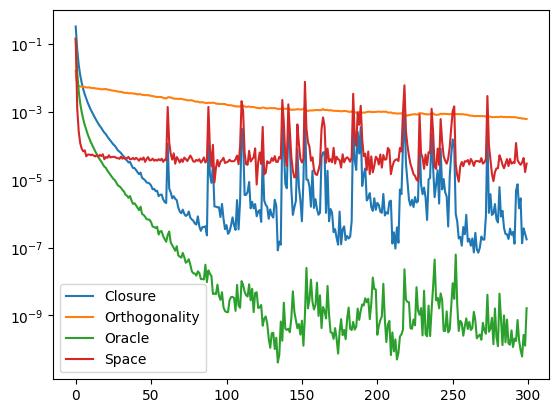

In [13]:
plt.plot(loss_S_closure, label =  "Closure")
plt.plot(loss_S_orth, label =  "Orthogonality")
plt.plot(loss_oracle, label =  "Oracle")
plt.plot(loss_space, label =  "Space")
plt.yscale("log")
plt.legend()

In [25]:
X, Y = next(iter(train_dataloader_Z))
X = X.to(device)
theta = 2*torch.ones(X.shape[0]) - 1 #Sampling
zero = torch.zeros(X.shape[0], device = device)
theta = theta.to(device)


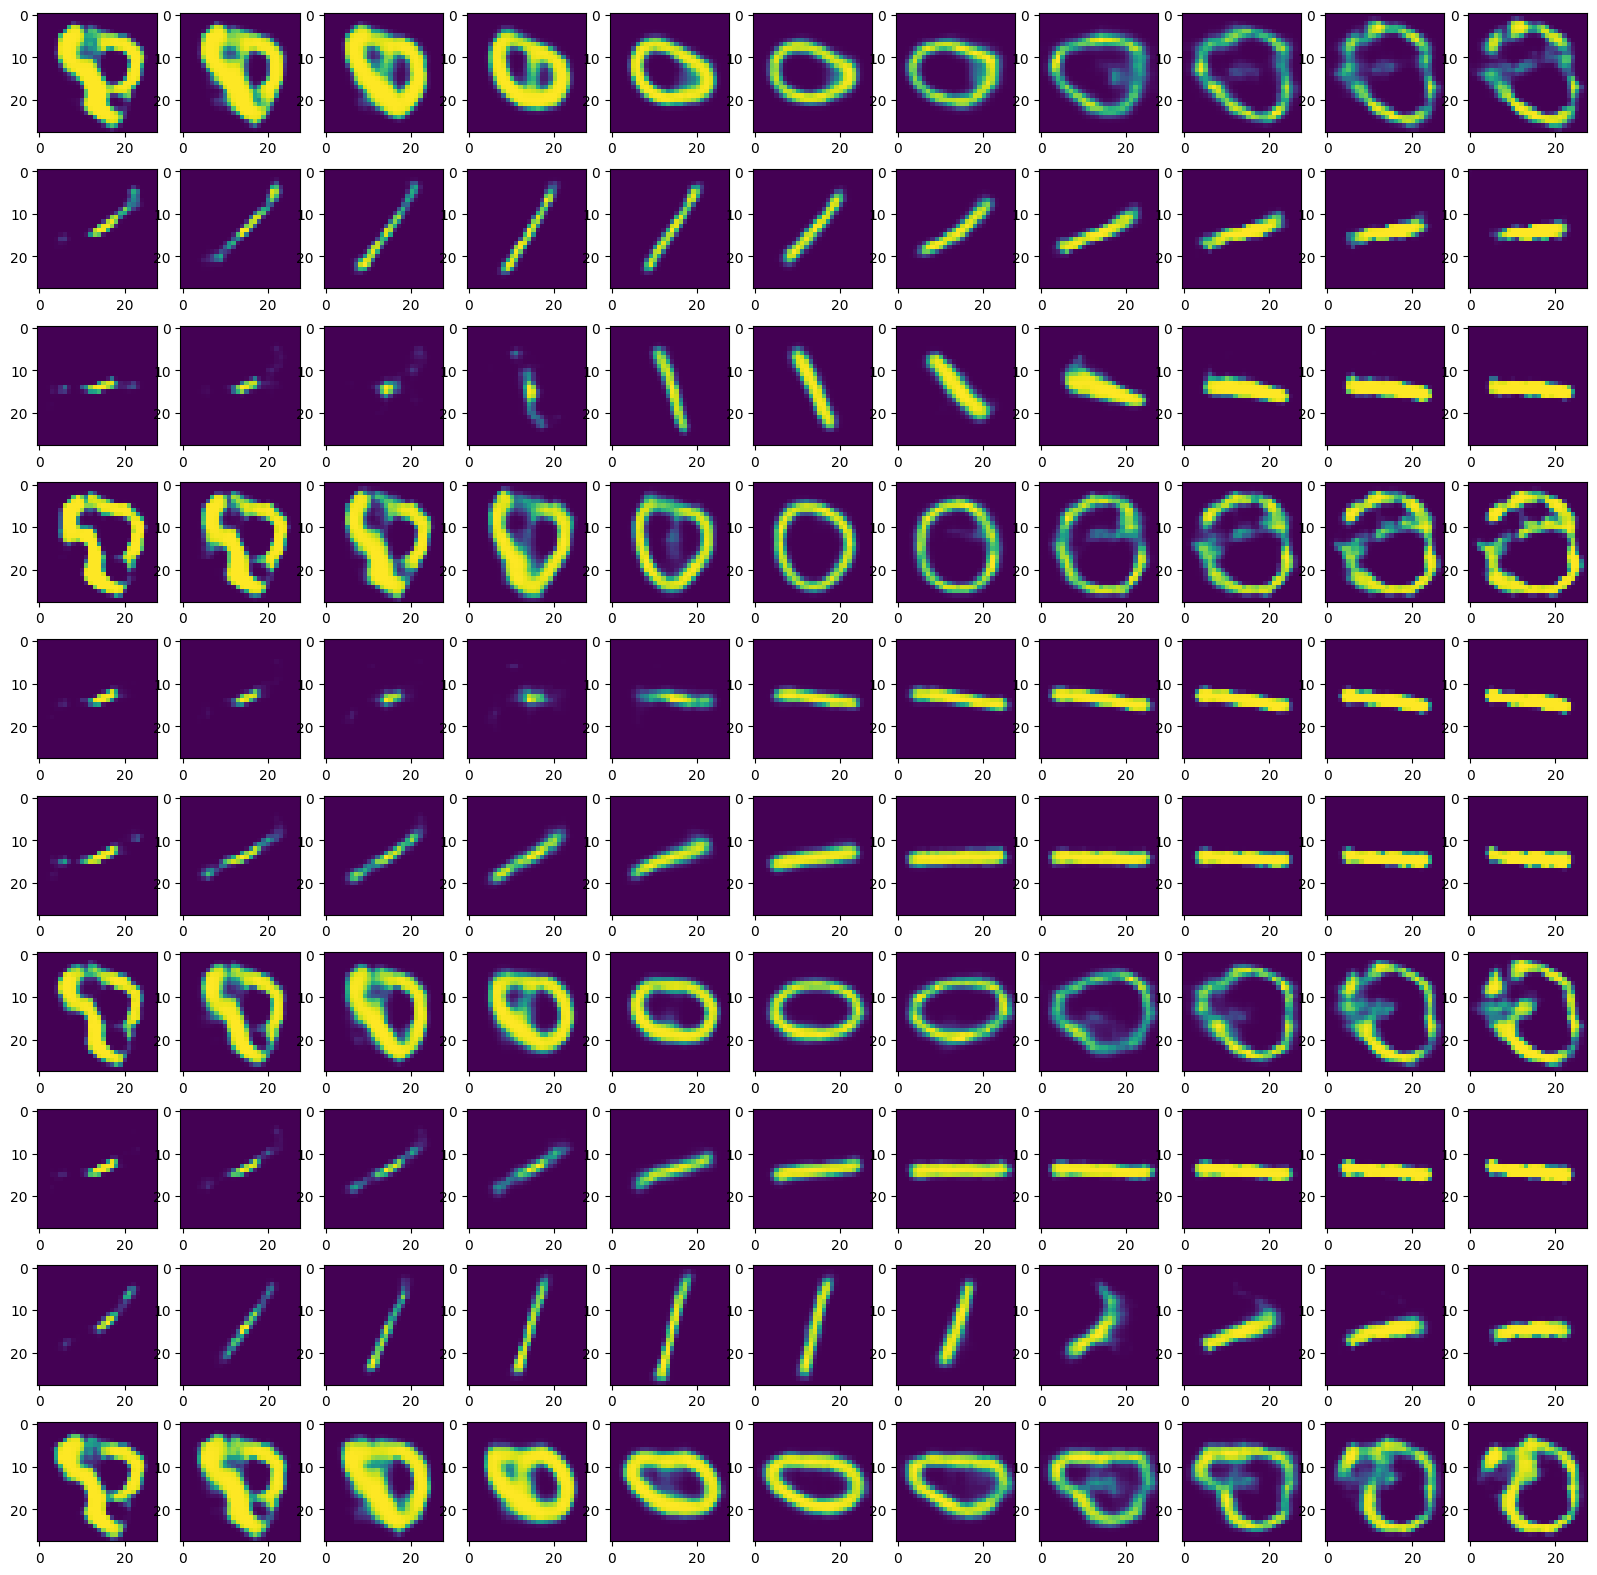

In [26]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([theta*(step),zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

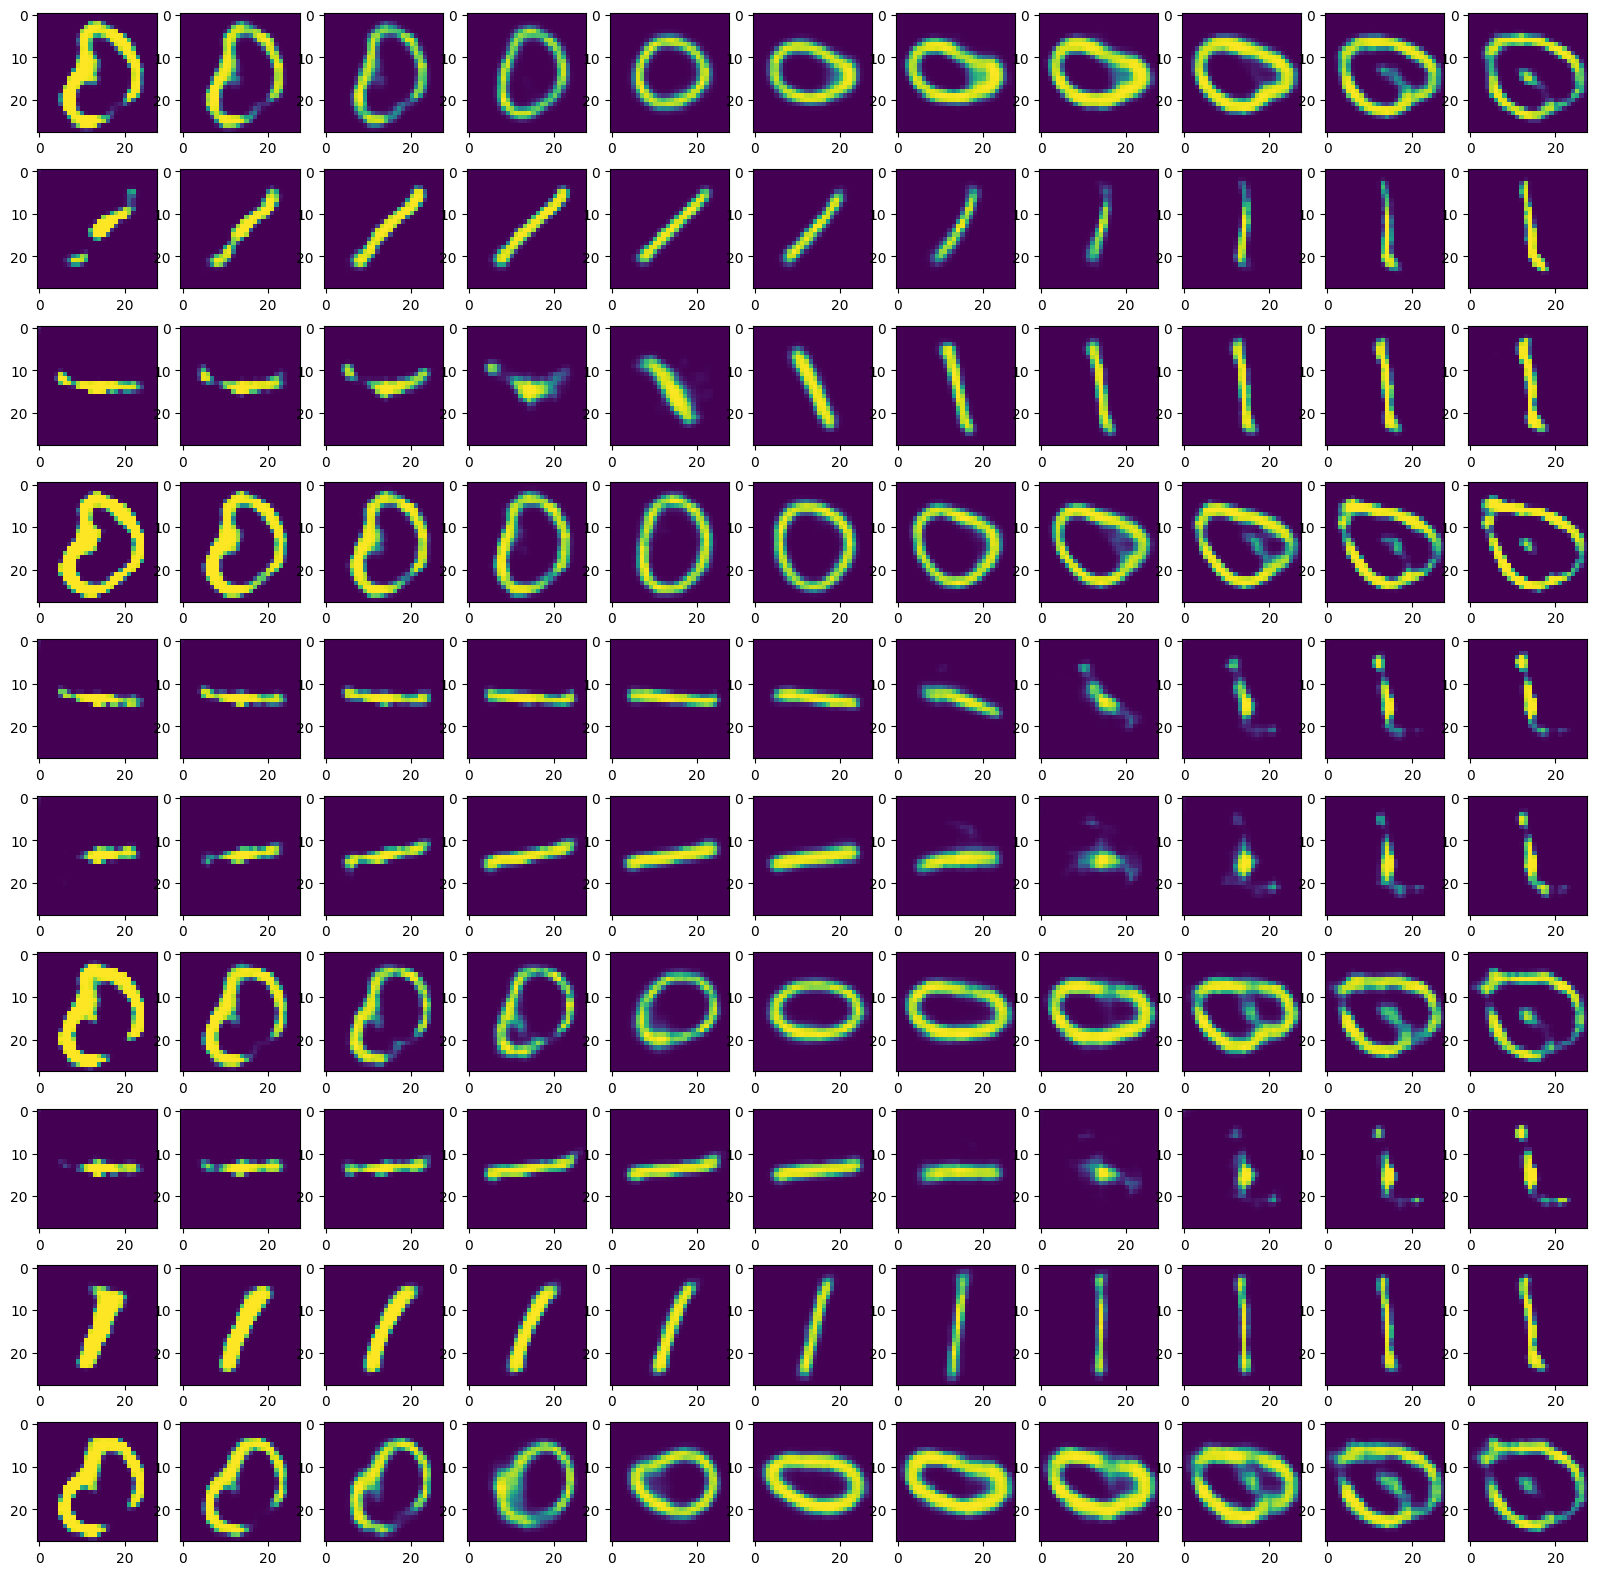

In [27]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,theta*(step),zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

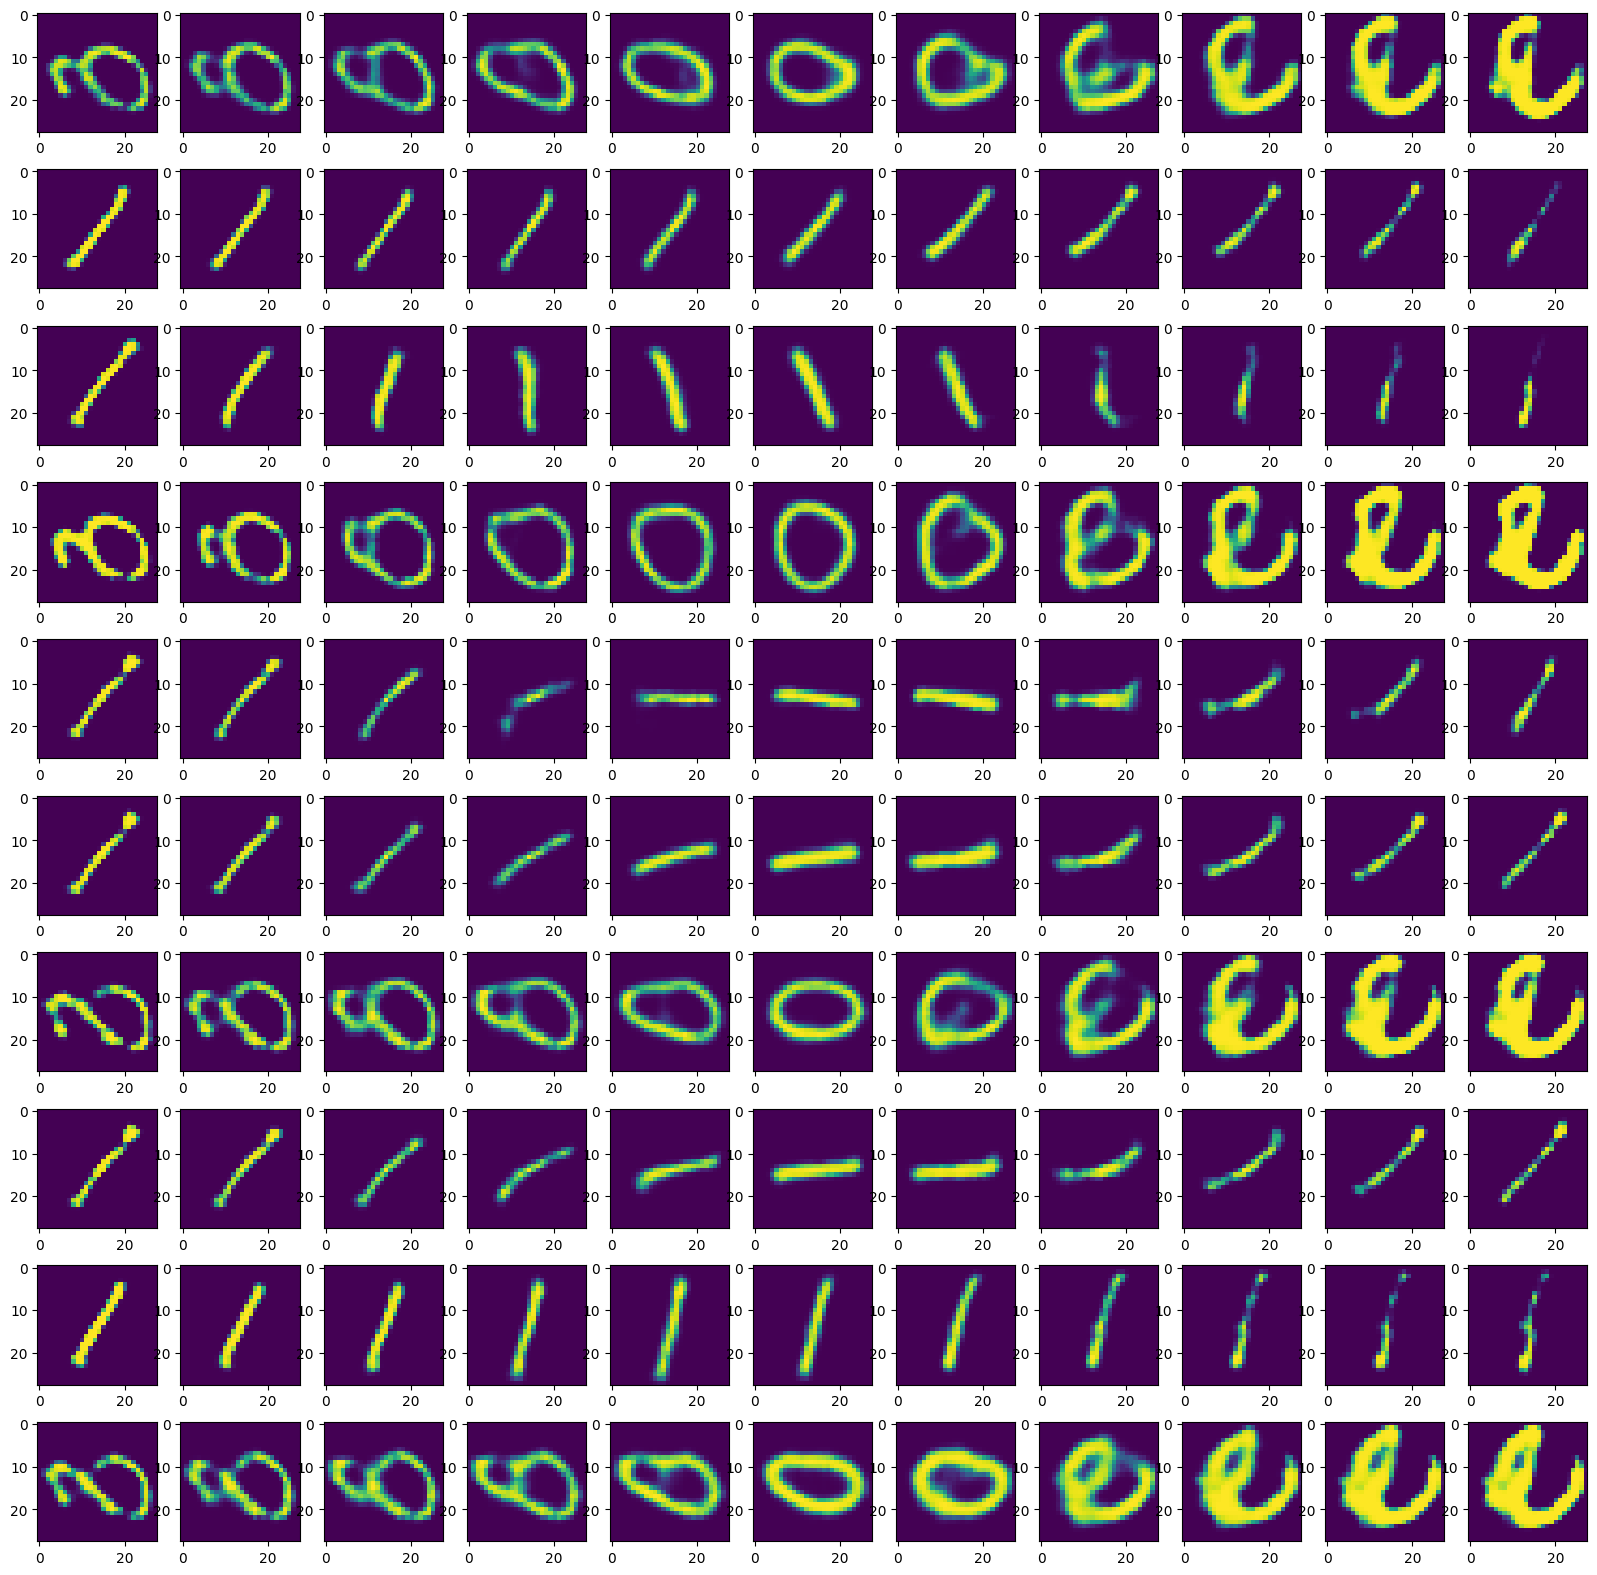

In [28]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,zero,theta*(step)],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

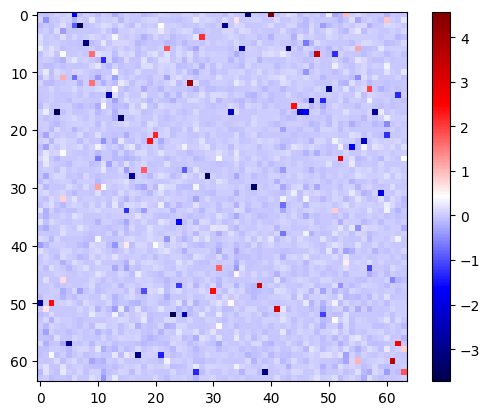

In [18]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

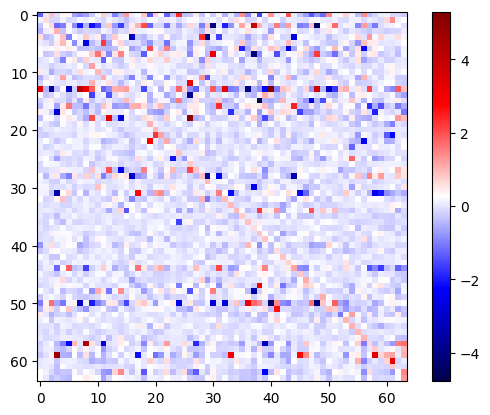

In [19]:
plt.imshow(torch.matrix_exp(model_symmetry.group[0].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

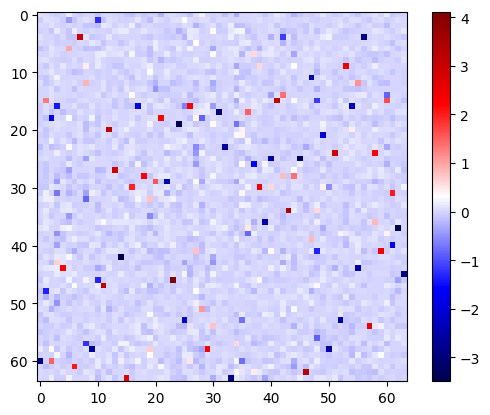

In [20]:
plt.imshow(model_symmetry.group[1].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

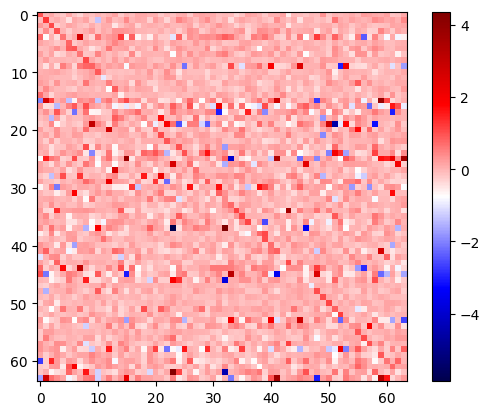

In [21]:
plt.imshow(torch.matrix_exp(model_symmetry.group[1].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

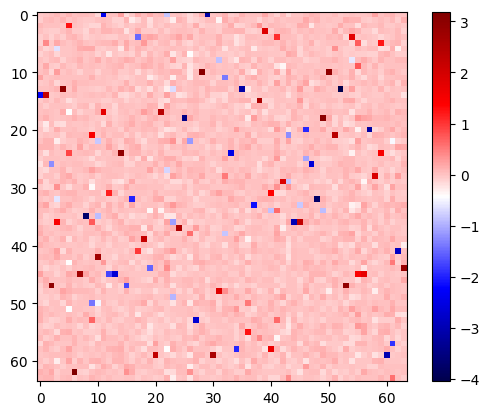

In [22]:
plt.imshow(model_symmetry.group[2].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

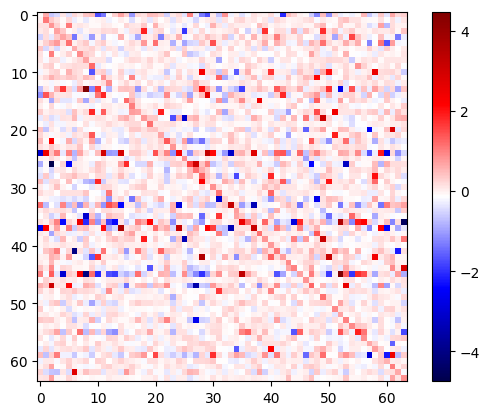

In [23]:
plt.imshow(torch.matrix_exp(model_symmetry.group[2].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()